# Modelling product affordability

_________________________________________________________________________________

### Problem: Predicting product affordability

The study sets out to determine whether we can model product affordability / pricing using the various product information available from the Sephora website (see list below). Because product pricing will naturally have to be influenced by volume, we are more interested in price per volume than the product price alone. 

Initially, the main objective is to predict the price per volume; however, we started with a presumably easier problem of determining how affordable the product is (category based on where it falls in the spectrum of cheap to premium products), turning this into a classification problem instead. 

The target variable for this model is the price per volume bins based on quantile. For interpretation, the price per volume range is provided below: 

**The target variable**

- Bottom 25%  
   - Price per volume: USD 0.00-  USD 9.99
- 25th-50th percentile:  
    - Price per volume: USD 10.00 - USD 32.94
- 50th-75th percentile:  
    - Price per volume: USD 32.94 - USD 72.00
- Top 25%: 
    - Price per volume: >USD 72.00


**A review of the features used**
- num_likes
- rating
- num_reviews
- sensitive_type
- combination_type
- oily_type
- normal_type
- dry_type
- clean_sephora
- cruelty_free
- vegan
- best_for_skintype
- award
- clinical_results
- (skin concern targeted) AcneBlemishes, AntiAging, DarkCircles, Darkspots, Dryness, DullnessUnevenTexture, HairDryness, Hydrating, Lossoffirmness, Pores, Redness
- num_excl_ingr
- (acids included) AHAGlycolicAcid, HyaluronicAcid, SalicylicAcid, VitaminC
- (formulation types) cream, gel, liquid, lotion, oil, others, serum
- (richnes of formula) heavy, light, normal
- (product_type) essences, serums & treatments, exfoliators & peels, eye cream and treatments, facial wash and cleansers
- brands

Through the modelling and analysis, we hope to uncover more insights about: 

- How does the skincare product industry price its products? 
    - Based on these trends, which products are over- or under-priced? 
- What are the most important determinants in product pricing? 
    - How much weight does branding play in pricing strategies? Do some brands have more consistent pricing over others? Are there any brands that stand out when it comes to product pricing? 
    - How are awards and publishing of clinical results related to higher prices? 
    - Are products targeting specific skincare concerns generally priced more expensively than others? How about those catering to specific skintypes (i.e. sensitive skin)?
    - Is price affected by ratings, number of ratings or likes, or number of reviews? 
- Are there specific ingredients that potentially drive up price? 

<font color='red'><bold>  NOTE: these should be addressed also in the EDA part. </bold> 

Think about commercial implications 
- this is interesting from a manufacturer's perspective mostly - how would my product be priced if it were up to the market / competitors? 
- given the basic product information, what would customers expect of price? how is it priced vs competitors? 
- can i compete in certain areas which have higher prices [??? think about this more]
 
</font>

__________________________________________________________________________________

**Reference file:**
- pre_modelling_df.json: cleaned dataset before train-test split

**Summary of training sets created**

We created:
- X_tr
- X_tr_scaled
- X_tr_select - scaled, top selected features from LR
- X_tr_select_final - scaled, optimally selected features from LR
- X_tr_selectsvm = unscaled, top 47 features based on SVM 
- X_tr_selectsvm = scaled, top 47 features based on SVM 

__________

<font color='red'> automatic creation of table of contents? </font>

__________

## 1.0 Loading file

In [1]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
import pydotplus
import re
import xgboost as xgb
import shap

In [2]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, log_loss, roc_curve
from sklearn.metrics import log_loss, matthews_corrcoef

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool
from sklearn import svm
from sklearn.pipeline import make_pipeline

In [4]:
from io import StringIO  
from IPython.display import Image  
from sklearn import tree, metrics
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

In [699]:
with open('../data/processed_data/pre_modelling_df.json', 'r') as file:
    data= json.load(file)
df=pd.DataFrame.from_dict(data)

In [700]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [701]:
#Editting and accessing this copy of the dataset
df1= df.copy()

## 2.0 Train-test split

In [7]:
targeted_var = 'affordability'
excluded_features = ['product_name', 
                    #y values 
                     'pricepervol', 'affordability', 'affordability_bins',
                     'highlighted_ingr', 'ingr_list'
                    ]

In [8]:
X= df.drop(columns=excluded_features)
y= df[targeted_var]

In [9]:
y = y.astype('category')

In [10]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size= 0.3, random_state=12,
                                        #stratify= y
                                         )

In [11]:
X_tr.shape, X_te.shape

((936, 175), (402, 175))

## 3.0 Feature engineering

In [12]:
#Create a copy of datasets
X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()

In [14]:
#Scale selected columns
scaler= StandardScaler()
X_tr_scaled[['num_likes', 'num_reviews']] = scaler.fit_transform(X_tr_scaled[['num_likes', 'num_reviews']])
X_te_scaled[['num_likes', 'num_reviews']]=  scaler.transform(X_te_scaled[['num_likes', 'num_reviews']])

## 4.0 Modelling

**Create custom-defined functions for model evaluation**

In [15]:
scores_list= ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'
             #,'f1_micro', 'precision_micro' #removed as not imbalanced
             ]

In [137]:
#Initiating empty dictionary to store model performance
cv_records={
    'Description': [],
    'Accuracy (CV test) mean': [],
    'Accuracy (CV test) std': [],
    'Accuracy (CV train) mean': [],
    'Accuracy (CV train) std': [],
    'Recall (CV test) mean': [],
    'Recall (CV test) std': [],
    'Precision (weighted, CV) mean': [],
    'Precision (weighted, CV) std': [],
    'F1 (weighted, CV) mean': [],
    'F1 (weighted, CV) std': []}

In [138]:
#Creating a function to fetch CV scores for various models
def eval_model(fitted_model, X_train, y_train, num_cv=5, scores= scores_list, title='Model evaluation', show_train_scores=False, save=False):
    '''
    Uses cross-validation and returns a report of model performance metrics
    '''
    cv_results= cross_validate(fitted_model, X_train, y_train, cv=num_cv, scoring = scores, return_train_score=True)
    print(title)
    
    print('\nTest scores: (mean, SD)')
    for i in list(map(str, scores)):
        metric = 'test_'+i
        print(f' {str(i).title()}: \n ({round(cv_results[str(metric)].mean(),4)}, {round(cv_results[str(metric)].std(),4)})')
        
    if show_train_scores:
        print('\nTraining scores:')
        for i in list(map(str, scores)):
            metric = 'train_'+i
            print(f' {str(i).title()}: \n ({round(cv_results[str(metric)].mean(),4)}, {round(cv_results[str(metric)].std(),4)})')    
    else:
        pass 
    
    if save==True:
        cv_records['Description'].append(title)
        cv_records['Accuracy (CV test) mean'].append(cv_results['test_accuracy'].mean())
        cv_records['Accuracy (CV test) std'].append(cv_results['test_accuracy'].std())
        cv_records['Accuracy (CV train) mean'].append(cv_results['train_accuracy'].mean())
        cv_records['Accuracy (CV train) std'].append(cv_results['train_accuracy'].std())
        cv_records['Recall (CV test) mean'].append(cv_results['test_recall_weighted'].mean())
        cv_records['Recall (CV test) std'].append(cv_results['test_recall_weighted'].std())
        cv_records['Precision (weighted, CV) mean'].append(cv_results['test_precision_weighted'].mean())
        cv_records['Precision (weighted, CV) std'].append(cv_results['test_precision_weighted'].std())
        cv_records['F1 (weighted, CV) mean'].append(cv_results['test_f1_weighted'].mean())
        cv_records['F1 (weighted, CV) std'].append(cv_results['test_f1_weighted'].std())
    else:
        pass

In [19]:
#Creating a function to show ROC for various classes
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    '''
    Returns a dictionary showing ROC-AUC score per class
    '''
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    scores=[]
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        scores.append(roc_auc)
        roc_auc_dict[per_class] = round(roc_auc,4)

    print(f'Average ROC AUC score: {round(np.mean(scores),4)}')
    return roc_auc_dict

In [20]:
def plot_cm(fitted_model, X_test, y_test):
    '''
    Prints both normalized and non-normalized confusion matrix
    '''
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix, without normalization:", None),
                              ("Normalized confusion matrix:", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(fitted_model, X_test, y_test,
                                     display_labels=['0','1','2','3'], #used € since $ won't work
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

In [374]:
test_records={
    'Description': [],
    'Accuracy': [],
    'ROC-AUC-1': [],
    'ROC-AUC-2': [],
    'ROC-AUC-3': [],
    'ROC-AUC-4': [],
    'F1_weighted': []}

In [375]:
def evaluate_test(fittedmodel, X_tr, X_te, y_tr, y_te, description='no description', save=False):
    '''
    Fit model and returns results on test set 
    '''
    #Fit the model 
    fittedmodel.fit(X_tr, y_tr)
    y_te_pred = fittedmodel.predict(X_te)
    print('Accuracy score on test:', accuracy_score(y_te, y_te_pred))
    lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred)
    print(lr_roc_auc_multiclass)
    print('Classification report: \n', classification_report(y_te, y_te_pred))
    plot_cm(fittedmodel, X_te, y_te)
    
    if save==True:
        test_records['Description'].append(description)
        test_records['Accuracy'].append(accuracy_score(y_te, y_te_pred))
        test_records['ROC-AUC-1'].append(lr_roc_auc_multiclass['$'])
        test_records['ROC-AUC-2'].append(lr_roc_auc_multiclass['$$'])
        test_records['ROC-AUC-3'].append(lr_roc_auc_multiclass['$$$'])
        test_records['ROC-AUC-4'].append(lr_roc_auc_multiclass['$$$$'])
        test_records['F1_weighted'].append(classification_report(y_te, y_te_pred, output_dict=True)['weighted avg']['f1-score'])

## 4.1 Classifiers

### Logistic Regression

#### I. Create base model for logistic regression

In [123]:
#Building base logistic regression model 
logreg= LogisticRegression(solver='saga', random_state=1, max_iter=1000) 

In [124]:
logreg.fit(X_tr_scaled, y_tr)
y_tr_pred = logreg.predict(X_tr_scaled)
y_te_pred = logreg.predict(X_te_scaled)

In [139]:
#Cross validated score
eval_model(logreg, X_tr_scaled, y_tr, 5, scores_list, 'LR - scaled training set, base (saga)', True, True)

LR - scaled training set, base (saga)

Test scores: (mean, SD)
 Accuracy: 
 (0.6303, 0.0415)
 F1_Weighted: 
 (0.6265, 0.0436)
 Precision_Weighted: 
 (0.6254, 0.0453)
 Recall_Weighted: 
 (0.6303, 0.0415)

Training scores:
 Accuracy: 
 (0.7853, 0.0096)
 F1_Weighted: 
 (0.7845, 0.0098)
 Precision_Weighted: 
 (0.7843, 0.0101)
 Recall_Weighted: 
 (0.7853, 0.0096)


Accuracy score on test: 0.6318407960199005
Average ROC AUC score: 0.7586
{'$': 0.8687, '$$$$': 0.8034, '$$': 0.7063, '$$$': 0.6558}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.82      0.79        98
          $$       0.56      0.56      0.56       103
         $$$       0.54      0.46      0.50       111
        $$$$       0.64      0.72      0.68        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.63      0.63      0.63       402

Confusion matrix, without normalization:
[[80 13  5  0]
 [17 58 21  7]
 [ 5 26 51 29]
 [ 2  6 17 65]]
Normalized confusion matrix:
[[0.82 0.13 0.05 0.  ]
 [0.17 0.56 0.2  0.07]
 [0.05 0.23 0.46 0.26]
 [0.02 0.07 0.19 0.72]]


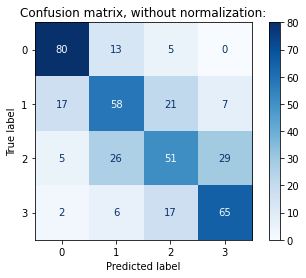

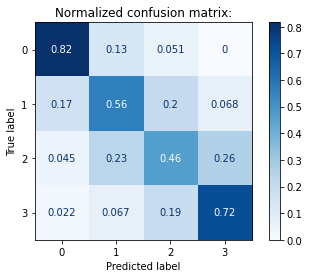

In [376]:
evaluate_test(logreg, X_tr_scaled, X_te_scaled, y_tr, y_te, 'LR - scaled training set, base (saga)', True)

*The initial logistic regression model has a higher accuracy rate for the cheapest and the most expensive classes but less so on the mid-priced products.*

#### II. Tuning the logistic regression model

*Can we increase model performance by tuning the parameters?*

In [30]:
#Use GridSearch, optimizing for best accuracy
logreg_tuned=LogisticRegression(random_state=12)
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga'] #chose the ones which can handle multinomial loss
penalty = ['l2', 'l1', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg_tuned, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_tr_scaled, y_tr)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#store best parameters
logreg_opt_parameters = grid_result.best_params_

Best: 0.643491 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.628182 (0.034865) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.625357 (0.033834) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.632811 (0.033209) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.617139 (0.034749) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.617143 (0.034804) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.643491 (0.030503

In [38]:
bestlg = logreg_opt_parameters
bestlg

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

In [141]:
#Building another LR model using the best paramaters found 
logreg_opt = LogisticRegression(solver=bestlg['solver'], penalty=bestlg['penalty'], C=bestlg['C'], random_state=1)

In [142]:
#Cross validation performance
eval_model(logreg_opt, X_tr_scaled, y_tr, 5, scores_list, 'LR - scaled training set, tuned parameters', True, True)

LR - scaled training set, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6314, 0.0464)
 F1_Weighted: 
 (0.6293, 0.0464)
 Precision_Weighted: 
 (0.6292, 0.0466)
 Recall_Weighted: 
 (0.6314, 0.0464)

Training scores:
 Accuracy: 
 (0.8459, 0.0143)
 F1_Weighted: 
 (0.8457, 0.0146)
 Precision_Weighted: 
 (0.8459, 0.0148)
 Recall_Weighted: 
 (0.8459, 0.0143)


Accuracy score on test: 0.6318407960199005
Average ROC AUC score: 0.7588
{'$': 0.8652, '$$$$': 0.8161, '$$': 0.6998, '$$$': 0.6541}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.81      0.79        98
          $$       0.55      0.55      0.55       103
         $$$       0.54      0.46      0.50       111
        $$$$       0.66      0.74      0.70        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.63      0.63      0.63       402

Confusion matrix, without normalization:
[[79 13  6  0]
 [17 57 24  5]
 [ 3 27 51 30]
 [ 3  6 14 67]]
Normalized confusion matrix:
[[0.81 0.13 0.06 0.  ]
 [0.17 0.55 0.23 0.05]
 [0.03 0.24 0.46 0.27]
 [0.03 0.07 0.16 0.74]]


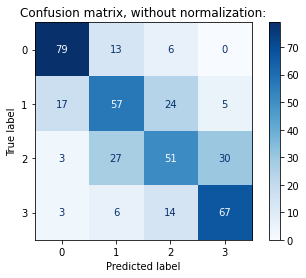

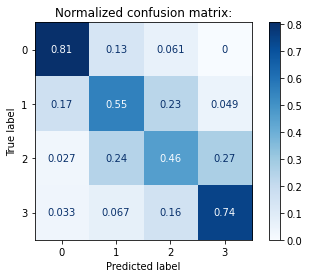

In [377]:
evaluate_test(logreg_opt, X_tr_scaled, X_te_scaled, y_tr, y_te, 'LR - scaled training set, tuned parameters', True)

*The performance of the tuned LR model is very close to the base LR, with minimal improvement in accuracy and precision metrics on the test set. On the training set, however, it has led to an uplift of c. 6% accuracy.* 

#### III. Insights from the model

*Which features are highly predictive of pricing?*

In [145]:
def plot_feature_importance(model, training_columns, method='abs_value', size=(12,25), n=-1):
    '''
    INPUT:
    model - fitted model such that there is a coefficient for the various features
    training_columns - X_train.columns 
    method - how to sort the graph ('abs_value' or 'coef')
    size - plot figure size
    n - top n number of features to show
    
    OUTPUT:
    Feature importance 
    '''
    fittedmodel = model
    title= model
    
    print('Model: ',title)
    
    if n<0:
        n= len(training_columns)
    print('Number of features displayed: {}/{}'.format(n, len(training_columns)))
    
    coef = np.transpose(fittedmodel.coef_.tolist()[0])
    lg_features= pd.DataFrame(zip(training_columns, coef, abs(coef)), columns=['features', 'coef', 'abs_value'])
    lg_features = lg_features.sort_values(method, ascending=False)
    
    zeroed = lg_features[lg_features.coef==0]
    print(f'Number of features with 0 coef: {len(zeroed)}')
    
    plt.figure(figsize=size)
    sns.barplot(y=lg_features.features[:n], x=lg_features.coef[:n], orient='h')
    plt.title('Feature Importance')
    #plt.savefig('topfeatures_lr.png', transparent= True, bbox_inches='tight')
    plt.show()

Model:  LogisticRegression(C=10, random_state=1, solver='newton-cg')
Number of features displayed: 175/175
Number of features with 0 coef: 12


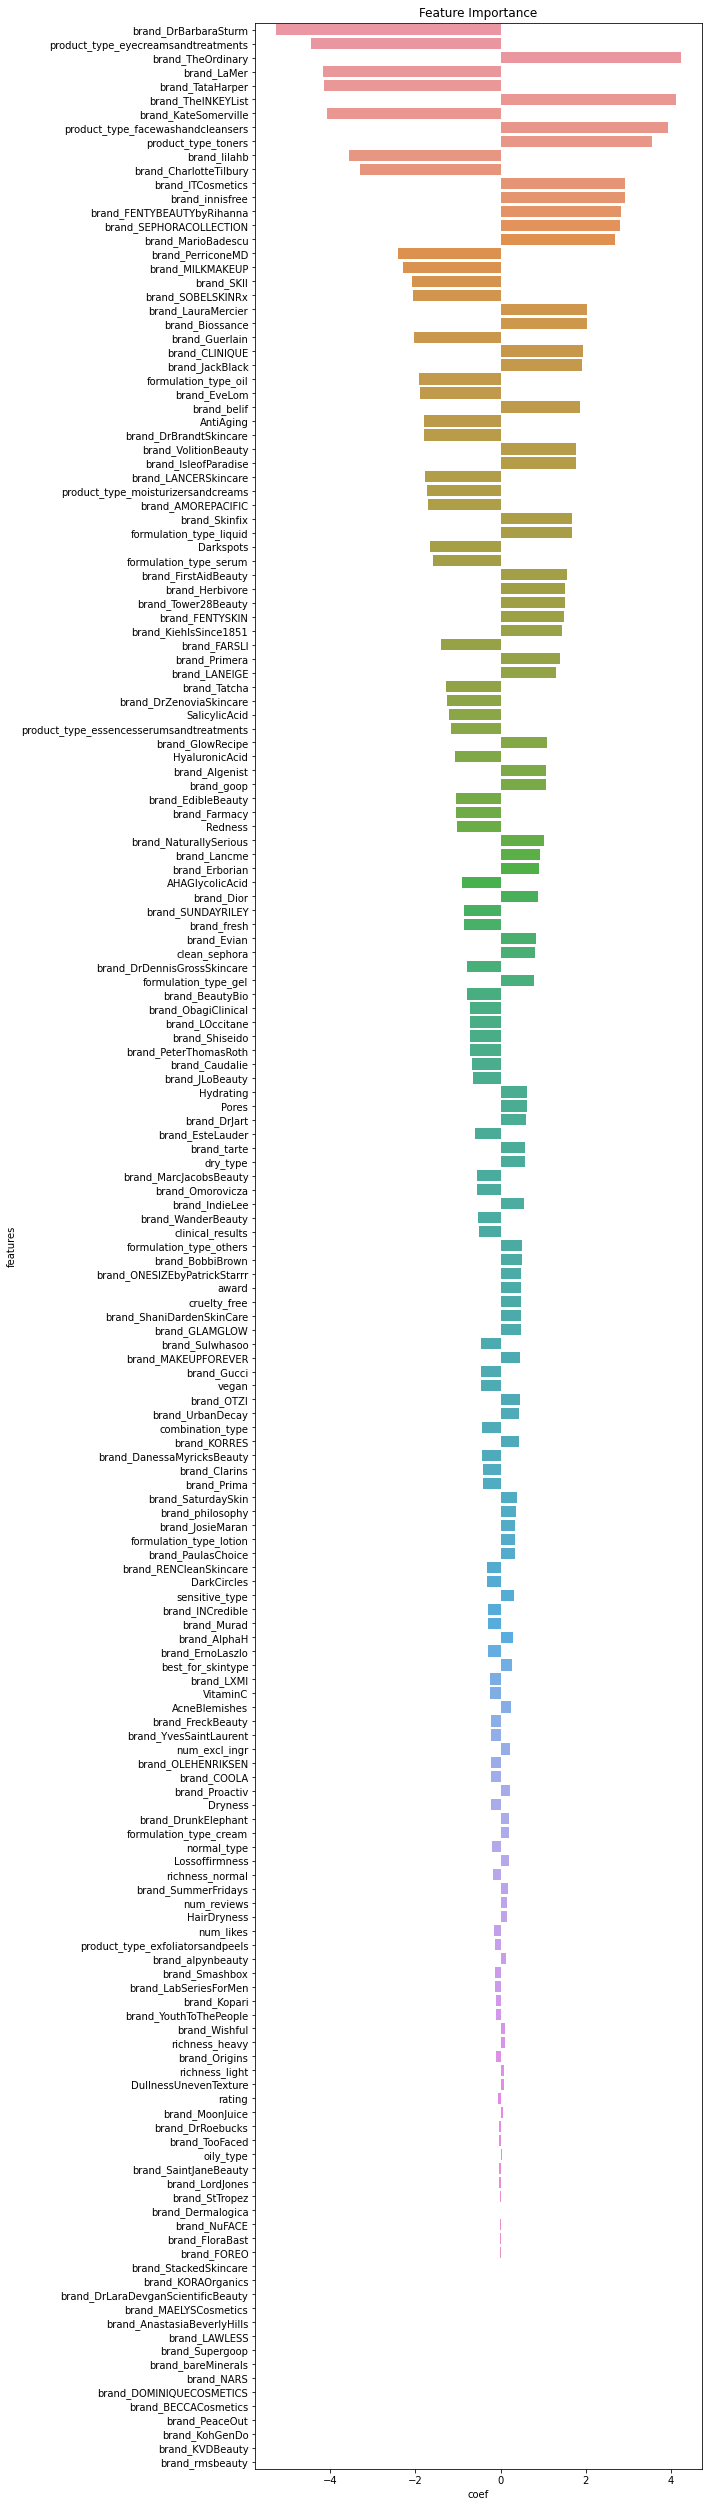

In [146]:
plot_feature_importance(logreg_opt, X_tr_scaled.columns, 'abs_value', (8, 45))

***Observations***

*Feature that are more predictive of pricing*
- Product type: coherent with initial findings during EDA 
- Certain formulation types  
- Numerous brands 
- Specific ingredients
- Specific skin concerns targeted 

*Feature that have less predictive power*
- Certain brands have less sway on the product affordability
- num_likes 
- light richness
- normal type 
- cream type formulation

*12 products have not been used in the model*

#### IV. Retrain the model with less features

*A. Based on logistic regression coefficients*

In [147]:
coef = np.transpose(logreg_opt.coef_.tolist()[0])
feat= pd.DataFrame(zip(X_tr_scaled.columns, coef, abs(coef)), columns=['features', 'coef', 'abs_value'])
feat = feat.sort_values('abs_value', ascending=False)
#zeroed = lg_features[lg_features.coef==0]
feat

features      coef  abs_value
64                  brand_DrBarbaraSturm -5.284226   5.284226
42   product_type_eyecreamsandtreatments -4.464634   4.464634
156                    brand_TheOrdinary  4.249815   4.249815
109                          brand_LaMer -4.179659   4.179659
153                     brand_TataHarper -4.154159   4.154159
..                                   ...       ...        ...
50                  brand_BECCACosmetics  0.000000   0.000000
131                       brand_PeaceOut  0.000000   0.000000
102                       brand_KohGenDo  0.000000   0.000000
99                       brand_KVDBeauty  0.000000   0.000000
173                      brand_rmsbeauty  0.000000   0.000000

[175 rows x 3 columns]

Try training on less features to see change in performance

In [205]:
num_features= 85 #random
selected_feat_col = feat[:num_features]['features'].tolist()
X_tr_sc_select = X_tr_scaled[selected_feat_col]
X_te_sc_select = X_te_scaled[selected_feat_col]

In [206]:
eval_model(logreg_opt, X_tr_sc_select, y_tr, 5, scores_list, 'LR - scaled and selected training data (chosen from LR), tuned hyperparameters', True)

LR - scaled and selected training data (chosen from LR), tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6582, 0.0393)
 F1_Weighted: 
 (0.6556, 0.04)
 Precision_Weighted: 
 (0.6567, 0.0408)
 Recall_Weighted: 
 (0.6582, 0.0393)

Training scores:
 Accuracy: 
 (0.7505, 0.0089)
 F1_Weighted: 
 (0.7495, 0.0096)
 Precision_Weighted: 
 (0.7497, 0.0107)
 Recall_Weighted: 
 (0.7505, 0.0089)


*This model shows a decrease in training accuracy performance (vs tuned model) but is able to retain similar performance on the test set. However, compared to the untuned logistic regression fitted on the full training set, it shows similar performance despite only using c. 49% of the features.*

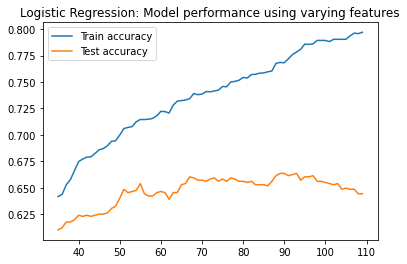

In [208]:
#Determine the optimal amount of features to use for the logistic regression model 
min_features= 35
max_features = 110
train_accuracy = []
test_accuracy= []
counter=[]
train_accuracy_sd= []
test_accuracy_sd= []
for i in range(min_features, max_features):
    feat_col = feat[:i]['features'].tolist()
    X_tr_sc_select = X_tr_scaled[feat_col]
    X_te_sc_select = X_te_scaled[feat_col]
    
    cv_results = cross_validate(logreg_opt, X_tr_sc_select, y_tr, cv=5, scoring='accuracy', return_train_score= True)
    test_accuracy.append(cv_results['test_score'].mean())
    train_accuracy.append(cv_results['train_score'].mean())
    counter.append(i)
    train_accuracy_sd.append(cv_results['train_score'].std())
    test_accuracy_sd.append(cv_results['test_score'].std())
    
sns.lineplot(x=counter, y=train_accuracy, label='Train accuracy')
sns.lineplot(x=counter, y=test_accuracy, label = 'Test accuracy')
plt.title('Logistic Regression: Model performance using varying features')
plt.show()

In [209]:
temp = pd.DataFrame({'num_features':counter, 'train_score': train_accuracy, 'test_score': test_accuracy})
temp.describe()

num_features  train_score  test_score
count     75.000000    75.000000   75.000000
mean      72.000000     0.737212    0.647037
std       21.794495     0.041725    0.013995
min       35.000000     0.641563    0.610075
25%       53.500000     0.710069    0.643190
50%       72.000000     0.740921    0.652827
75%       90.500000     0.770166    0.656571
max      109.000000     0.797010    0.663528

In [210]:
temp.sort_values('test_score', ascending=False)[:15]

num_features  train_score  test_score
55            90     0.768164    0.663528
54            89     0.768431    0.663528
58            93     0.778309    0.663506
57            92     0.775906    0.662436
56            91     0.771901    0.661389
53            88     0.767629    0.661389
62            97     0.786054    0.661361
32            67     0.734245    0.660320
61            96     0.785521    0.660297
60            95     0.785788    0.660297
38            73     0.741457    0.659256
33            68     0.739052    0.659245
42            77     0.750003    0.659239
37            72     0.740655    0.658181
43            78     0.750537    0.658175

*Through feature selection, we have achieved a better model performance for logistic regression.*

In [416]:
num_chosen_features= 76
selected_feat_col = feat[:num_chosen_features]['features'].tolist()

Create a new training set based on features selected through logistic regression 
(which we can use to train other models)

In [417]:
X_tr_sc_select = X_tr_scaled[selected_feat_col]
X_te_sc_select = X_te_scaled[selected_feat_col]

In [418]:
#Build a model based on optimised LR settings and selected features
logreg_opt.fit(X_tr_sc_select, y_tr)
y_tr_pred = logreg_opt.predict(X_tr_sc_select)
y_te_pred = logreg_opt.predict(X_te_sc_select)

In [419]:
#Evaluate the CV performance using selected features and optimised parameters 
eval_model(logreg_opt, X_tr_sc_select, y_tr, 5, scores_list, 'LR - scaled and selected (based on LR - 76), tuned hyperparameters', True)

LR - scaled and selected (based on LR - 76), tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.656, 0.0419)
 F1_Weighted: 
 (0.6541, 0.0426)
 Precision_Weighted: 
 (0.6549, 0.0433)
 Recall_Weighted: 
 (0.656, 0.0419)

Training scores:
 Accuracy: 
 (0.7455, 0.0102)
 F1_Weighted: 
 (0.7443, 0.0109)
 Precision_Weighted: 
 (0.7442, 0.0117)
 Recall_Weighted: 
 (0.7455, 0.0102)


*Based on cross-validated model performance, this model has the highest accuracy mean. On training set, however, the previous model still performs better.*

Accuracy score on test: 0.6218905472636815
Average ROC AUC score: 0.7516
{'$': 0.8738, '$$$$': 0.79, '$$': 0.6998, '$$$': 0.6428}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.83      0.80        98
          $$       0.55      0.55      0.55       103
         $$$       0.51      0.45      0.48       111
        $$$$       0.65      0.69      0.67        90

    accuracy                           0.62       402
   macro avg       0.62      0.63      0.62       402
weighted avg       0.62      0.62      0.62       402

Confusion matrix, without normalization:
[[81 12  5  0]
 [18 57 24  4]
 [ 5 26 50 30]
 [ 1  8 19 62]]
Normalized confusion matrix:
[[0.83 0.12 0.05 0.  ]
 [0.17 0.55 0.23 0.04]
 [0.05 0.23 0.45 0.27]
 [0.01 0.09 0.21 0.69]]


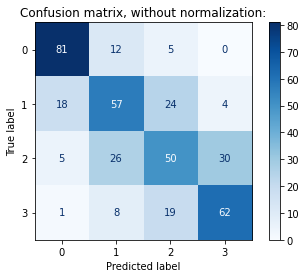

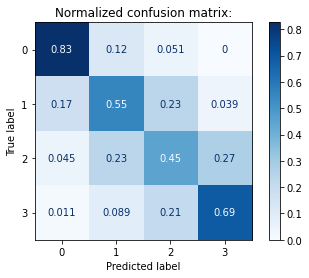

In [420]:
evaluate_test(logreg_opt, X_tr_sc_select, X_te_sc_select, y_tr, y_te, 'LR - scaled and selected (based on LR - 76), tuned hyperparameters', True)

> 76 - 62.12%, 75.16 roc auc

> 67 - 60%, 74

> 89 - 58.9%, 73 roc auc

*Comparing these to the previous logistic regression models trained on the full dataset, the feature selection has been beneficial as it allowed us to achieve roughly the same results (on both cross-validated and test set model performance) using only about 43% of the total features.*

*The scoring methods considered does not take into account the number of features used in the predictions. Generally, the more features used, the higher the score so some metrics like Adjusted R2 would penalize a model for using more variables. Taking this into account at a conceptual level, this LR model fitted on the selected feature set would be preferrable to the prior models. It will also be better for deployment with less data requirements.*

*B. Other feature selection methods*

Can feature selection through PCA yield better results for logistic regression?

In [225]:
pca= PCA(0.95) #retain 95% of variance
pca.fit(X_tr_scaled)

PCA(n_components=0.95)

In [226]:
#How many features would explain 95% of the variance?
pca.n_components_

66

*Great! This is in ballpark of the number of features used in the LR model earlier.*

In [235]:
#Transform both training and test set 
X_tr_sc_pca = pca.transform(X_tr_scaled)
X_te_sc_pca = pca.transform(X_tr_scaled)

In [236]:
eval_model(logreg, X_tr_sc_pca, y_tr, 5, scores_list, 'LR - PCA scaled training set, base model', True, True)

LR - PCA scaled training set, base model

Test scores: (mean, SD)
 Accuracy: 
 (0.5993, 0.0351)
 F1_Weighted: 
 (0.5965, 0.0372)
 Precision_Weighted: 
 (0.597, 0.0403)
 Recall_Weighted: 
 (0.5993, 0.0351)

Training scores:
 Accuracy: 
 (0.7102, 0.0082)
 F1_Weighted: 
 (0.7095, 0.0085)
 Precision_Weighted: 
 (0.709, 0.0088)
 Recall_Weighted: 
 (0.7102, 0.0082)


*Model performance is not better than previously trained LR model.*

### Support Vector Machines (SVM)

Default kernel is rbf but let's check if a different kernel would yield better results

In [241]:
#Initiate SVM models with different kernels; used 'ovo' for multiclass strategy
linear = svm.SVC(kernel='linear', decision_function_shape='ovo', random_state=123)
rbf = svm.SVC(kernel='rbf', decision_function_shape='ovo', random_state=123)
poly = svm.SVC(kernel='poly', degree=3, decision_function_shape='ovo', random_state=123)
sig = svm.SVC(kernel='sigmoid', decision_function_shape='ovo', random_state=123)

In [242]:
linear.fit(X_tr_scaled, y_tr)
poly.fit(X_tr_scaled, y_tr)
rbf.fit(X_tr_scaled, y_tr)
sig.fit(X_tr_scaled, y_tr)
y_te_pred_lin = linear.predict(X_te_scaled)
y_te_pred_poly = poly.predict(X_te_scaled)
y_te_pred_rbf = rbf.predict(X_te_scaled)
y_te_pred_sig = sig.predict(X_te_scaled)

In [243]:
#Check initial accuracy scores on the test set to get a rough idea of performance
print('Support vector machine - base')
print(f' Accuracy Linear Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_lin))
print(f' Accuracy Polynomial Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_poly))
print(f' Accuracy Radial Basis Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_rbf))
print(f' Accuracy Sigmoid Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_sig))

Support vector machine - base
 Accuracy Linear Kernel: 	 0.6443
 Accuracy Polynomial Kernel: 	 0.6318
 Accuracy Radial Basis Kernel: 	 0.6269
 Accuracy Sigmoid Kernel: 	 0.5846


*Linear kernel performs best. As the scores are not significantly different, let's check the cross-validation scores.*

In [244]:
#To evaluate with cross-validation
eval_model(linear, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, linear kernel', True)

SVM - scaled training set, linear kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.6314, 0.0348)
 F1_Weighted: 
 (0.6301, 0.0359)
 Precision_Weighted: 
 (0.6318, 0.0374)
 Recall_Weighted: 
 (0.6314, 0.0348)

Training scores:
 Accuracy: 
 (0.8181, 0.0079)
 F1_Weighted: 
 (0.8184, 0.0079)
 Precision_Weighted: 
 (0.8191, 0.0079)
 Recall_Weighted: 
 (0.8181, 0.0079)


In [250]:
eval_model(poly, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, polynomial (3) kernel', True)

SVM - scaled training set, polynomial (3) kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.5961, 0.0298)
 F1_Weighted: 
 (0.5967, 0.0314)
 Precision_Weighted: 
 (0.6055, 0.0382)
 Recall_Weighted: 
 (0.5961, 0.0298)

Training scores:
 Accuracy: 
 (0.7155, 0.0099)
 F1_Weighted: 
 (0.7166, 0.0097)
 Precision_Weighted: 
 (0.7211, 0.0091)
 Recall_Weighted: 
 (0.7155, 0.0099)


In [251]:
eval_model(poly, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, radial basis kernel', True)

SVM - scaled training set, radial basis kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.5961, 0.0298)
 F1_Weighted: 
 (0.5967, 0.0314)
 Precision_Weighted: 
 (0.6055, 0.0382)
 Recall_Weighted: 
 (0.5961, 0.0298)

Training scores:
 Accuracy: 
 (0.7155, 0.0099)
 F1_Weighted: 
 (0.7166, 0.0097)
 Precision_Weighted: 
 (0.7211, 0.0091)
 Recall_Weighted: 
 (0.7155, 0.0099)


In [252]:
eval_model(sig, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, sigmoid kernel', True)

SVM - scaled training set, sigmoid kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.563, 0.0313)
 F1_Weighted: 
 (0.5582, 0.0347)
 Precision_Weighted: 
 (0.5623, 0.0399)
 Recall_Weighted: 
 (0.563, 0.0313)

Training scores:
 Accuracy: 
 (0.598, 0.009)
 F1_Weighted: 
 (0.5949, 0.0093)
 Precision_Weighted: 
 (0.5962, 0.0085)
 Recall_Weighted: 
 (0.598, 0.009)


*With cross-validation, the gap between the model performance widens, confirming that the linear kernel SVM is superior to the others*

Accuracy score on test: 0.6442786069651741
Average ROC AUC score: 0.7656
{'$': 0.8738, '$$$$': 0.7932, '$$': 0.7195, '$$$': 0.676}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.83      0.80        98
          $$       0.60      0.57      0.58       103
         $$$       0.55      0.51      0.53       111
        $$$$       0.66      0.69      0.67        90

    accuracy                           0.64       402
   macro avg       0.64      0.65      0.65       402
weighted avg       0.64      0.64      0.64       402

Confusion matrix, without normalization:
[[81 12  5  0]
 [15 59 22  7]
 [ 6 23 57 25]
 [ 3  5 20 62]]
Normalized confusion matrix:
[[0.83 0.12 0.05 0.  ]
 [0.15 0.57 0.21 0.07]
 [0.05 0.21 0.51 0.23]
 [0.03 0.06 0.22 0.69]]


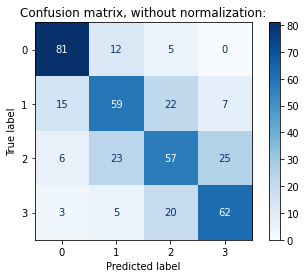

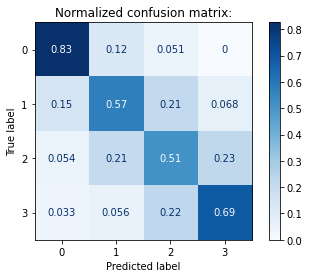

In [379]:
evaluate_test(linear, X_tr_scaled, X_te_scaled, y_tr, y_te, 'SVM - scaled training set, linear kernel', True)

*Compared to the best model so far (LR trained on selected feature set), SVM has shown a similar cross-validated model performance. On the test set, it performs slightly better by c. 1%. It also achieved a higher f1 score for 1st, 2nd, 3rd classes, noting that earlier models had a bigger challenge distinguishing between the 2nd and 3rd (i.e. the average products).*

*As shown in the CM above, SVM has increased accuracy for 1,2,3 but is less accurate for the class 4.*

What features did the SVM use to make these predictions?

In [255]:
linear = svm.SVC(kernel='linear', decision_function_shape='ovo')
linear.fit(X_tr_scaled, y_tr)

SVC(decision_function_shape='ovo', kernel='linear')

Model:  SVC(decision_function_shape='ovo', kernel='linear')
Number of features displayed: 175/175
Number of features with 0 coef: 52


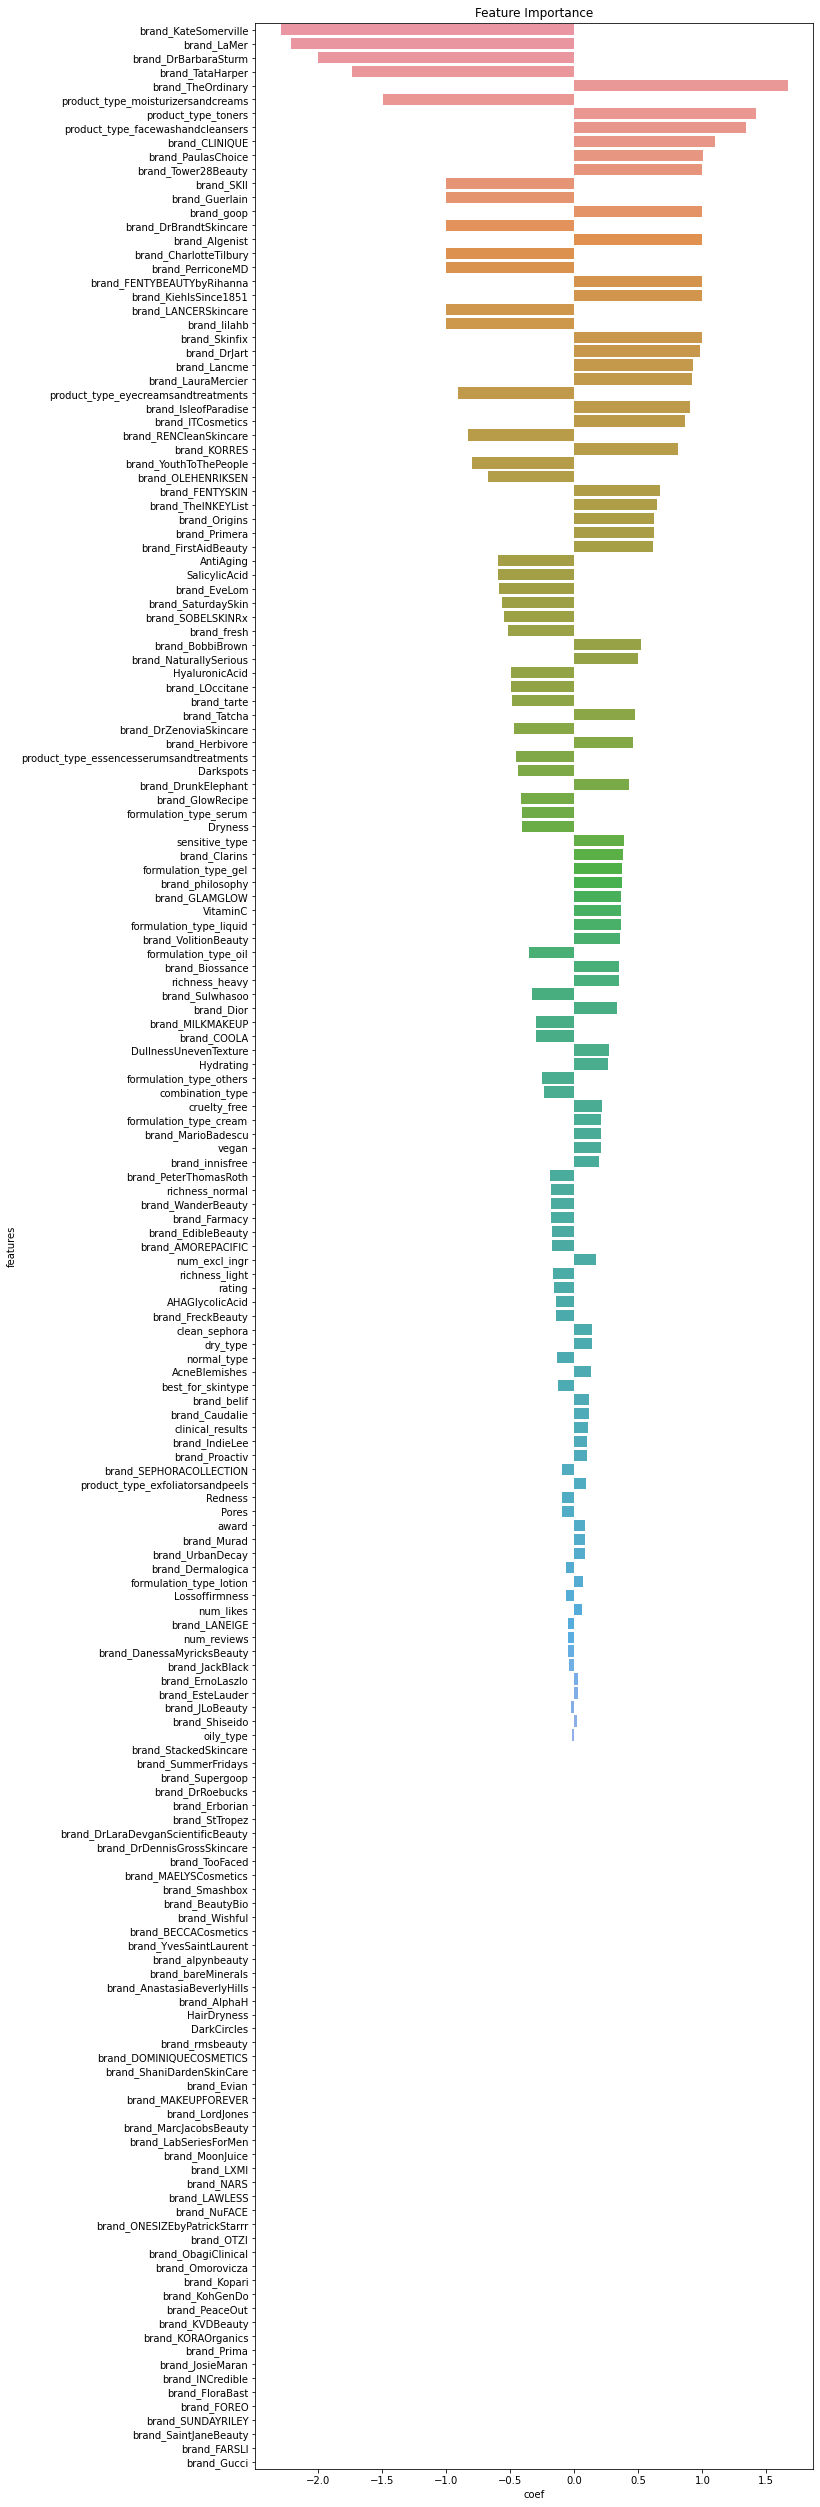

In [256]:
plot_feature_importance(linear, X_tr_scaled.columns, 'abs_value', (10,45))

#### Insights from the model: 

- Patterns in the highly and least predictive features have a significant overlap with what was found through logistic regression with top predictive features consisting mostly brands and product type. 
- In the SVM, 52 features had no predictive power (majority of these were also are particular brands).
- Number of reviews and number of likes have low predictive power in this model. 

In [257]:
tempsvm= pd.DataFrame({'feature': X_tr_scaled.columns.tolist(), 
              'coef':linear.coef_[0], 
             'abs_values': abs(linear.coef_[0])}).sort_values('abs_values', ascending=False)

In [261]:
#Determine the optimal amount of features to use for the SVM model 
min_features= 35
max_features = 123
train_accuracy = []
test_accuracy= []
counter=[]
train_accuracy_sd= []
test_accuracy_sd= []
for i in range(min_features, max_features):
    X_tr_sc_selectsvm = X_tr_scaled[tempsvm[:i].feature.tolist()]
    X_te_sc_selectsvm = X_te_scaled[tempsvm[:i].feature.tolist()]

    cv_results = cross_validate(linear, X_tr_sc_selectsvm, y_tr, cv=5, scoring='accuracy', return_train_score= True)
    test_accuracy.append(cv_results['test_score'].mean())
    train_accuracy.append(cv_results['train_score'].mean())
    counter.append(i)
    train_accuracy_sd.append(cv_results['train_score'].std())
    test_accuracy_sd.append(cv_results['test_score'].std())

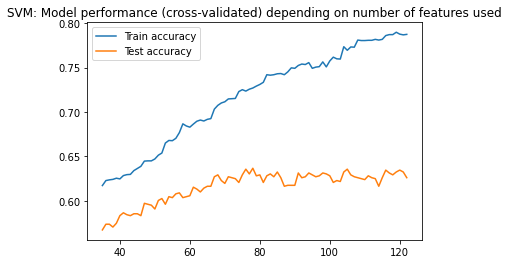

In [262]:
sns.lineplot(x=counter, y=train_accuracy, label='Train accuracy')
sns.lineplot(x=counter, y=test_accuracy, label = 'Test accuracy')
plt.title('SVM: Model performance (cross-validated) depending on number of features used')
plt.show()

In [267]:
#Which 
tempsvm1 = pd.DataFrame({'num_features':counter, 'train_score': train_accuracy, 'test_score': test_accuracy})
tempsvm1[tempsvm1.test_score==tempsvm1.test_score.max()]

num_features  train_score  test_score
43            78     0.727032    0.636745

Create a new training set based on feature importance found through SVM 

In [270]:
#unscaled
n= 78
X_tr_selectsvm = X_tr[tempsvm[:n].feature.tolist()]
X_te_selectsvm = X_te[tempsvm[:n].feature.tolist()]

#scaled
X_tr_sc_selectsvm = X_tr_scaled[tempsvm[:n].feature.tolist()]
X_te_sc_selectsvm = X_te_scaled[tempsvm[:n].feature.tolist()]

#### Evaluate SVM on selected features

In [275]:
#SVM based on feature selection through SVM 
eval_model(linear, X_tr_sc_selectsvm, y_tr, 5, scores_list, 'SVM - scaled training set, selected features using SVM, linear kernel', True, True)

SVM - scaled training set, selected features using SVM, linear kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.6367, 0.0238)
 F1_Weighted: 
 (0.6373, 0.0257)
 Precision_Weighted: 
 (0.6465, 0.0301)
 Recall_Weighted: 
 (0.6367, 0.0238)

Training scores:
 Accuracy: 
 (0.727, 0.0108)
 F1_Weighted: 
 (0.7289, 0.0116)
 Precision_Weighted: 
 (0.7364, 0.0127)
 Recall_Weighted: 
 (0.727, 0.0108)


In [276]:
#SVM based on PCA features
eval_model(linear, X_tr_pca, y_tr, 5, scores_list, 'SVM - PCA features, linear', True)

SVM - PCA features, linear

Test scores: (mean, SD)
 Accuracy: 
 (0.594, 0.0262)
 F1_Weighted: 
 (0.5954, 0.0292)
 Precision_Weighted: 
 (0.6019, 0.0349)
 Recall_Weighted: 
 (0.594, 0.0262)

Training scores:
 Accuracy: 
 (0.7217, 0.0059)
 F1_Weighted: 
 (0.7236, 0.006)
 Precision_Weighted: 
 (0.7269, 0.0067)
 Recall_Weighted: 
 (0.7217, 0.0059)


In [278]:
#SVM based on LR feature selection
eval_model(linear, X_tr_sc_select, y_tr, 5, scores_list,'SVM - scaled training set, selected features using LR', True, True)

SVM - scaled training set, selected features using LR

Test scores: (mean, SD)
 Accuracy: 
 (0.6571, 0.0403)
 F1_Weighted: 
 (0.6545, 0.0418)
 Precision_Weighted: 
 (0.6622, 0.0398)
 Recall_Weighted: 
 (0.6571, 0.0403)

Training scores:
 Accuracy: 
 (0.7262, 0.0089)
 F1_Weighted: 
 (0.7265, 0.0086)
 Precision_Weighted: 
 (0.7307, 0.0093)
 Recall_Weighted: 
 (0.7262, 0.0089)


*Using SVM on the selected features from logistic regression shows a relative high cross-validated performance. How does it perform on the test set?*

Accuracy score on test: 0.664179104477612
Average ROC AUC score: 0.7791
{'$': 0.8802, '$$$$': 0.7987, '$$': 0.7579, '$$$': 0.6797}
Classification report: 
               precision    recall  f1-score   support

           $       0.82      0.82      0.82        98
          $$       0.59      0.68      0.63       103
         $$$       0.59      0.49      0.53       111
        $$$$       0.66      0.70      0.68        90

    accuracy                           0.66       402
   macro avg       0.67      0.67      0.67       402
weighted avg       0.66      0.66      0.66       402

Confusion matrix, without normalization:
[[80 14  4  0]
 [13 70 18  2]
 [ 2 25 54 30]
 [ 2 10 15 63]]
Normalized confusion matrix:
[[0.82 0.14 0.04 0.  ]
 [0.13 0.68 0.17 0.02]
 [0.02 0.23 0.49 0.27]
 [0.02 0.11 0.17 0.7 ]]


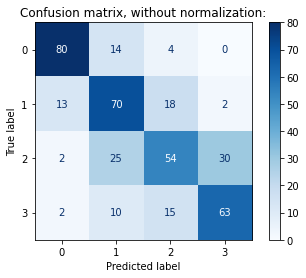

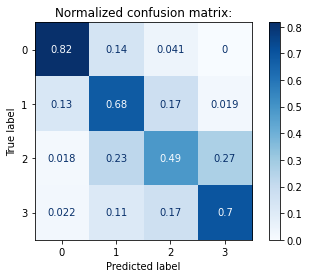

In [392]:
#Performance on test set 
evaluate_test(linear, X_tr_sc_select, X_te_sc_select, y_tr, y_te, 'SVM - scaled training set, selected features using LR', True)

*Good result and so far the highest accuracy on the test set!*

*How well will the SVM feature set do using other models?*

In [283]:
eval_model(logreg_opt, X_tr_sc_selectsvm, y_tr, 5, scores_list,'LR - SVM feature set, tuned hyperparameters', True, True)

LR - SVM feature set, tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6335, 0.0329)
 F1_Weighted: 
 (0.6305, 0.0376)
 Precision_Weighted: 
 (0.6329, 0.0401)
 Recall_Weighted: 
 (0.6335, 0.0329)

Training scores:
 Accuracy: 
 (0.7532, 0.0077)
 F1_Weighted: 
 (0.7535, 0.0079)
 Precision_Weighted: 
 (0.7552, 0.0086)
 Recall_Weighted: 
 (0.7532, 0.0077)


Accuracy score on test: 0.6119402985074627
Average ROC AUC score: 0.7446
{'$': 0.8756, '$$$$': 0.786, '$$': 0.6641, '$$$': 0.6528}
Classification report: 
               precision    recall  f1-score   support

           $       0.76      0.84      0.80        98
          $$       0.52      0.49      0.50       103
         $$$       0.51      0.48      0.50       111
        $$$$       0.65      0.68      0.66        90

    accuracy                           0.61       402
   macro avg       0.61      0.62      0.61       402
weighted avg       0.60      0.61      0.61       402

Confusion matrix, without normalization:
[[82 12  4  0]
 [18 50 29  6]
 [ 5 26 53 27]
 [ 3  9 17 61]]
Normalized confusion matrix:
[[0.84 0.12 0.04 0.  ]
 [0.17 0.49 0.28 0.06]
 [0.05 0.23 0.48 0.24]
 [0.03 0.1  0.19 0.68]]


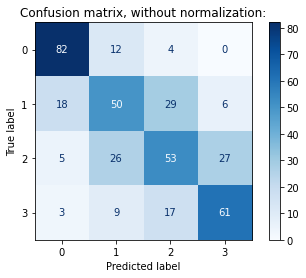

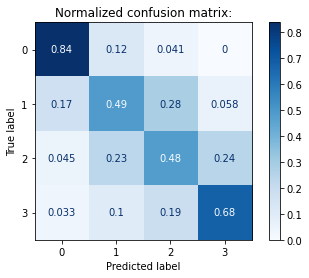

In [381]:
evaluate_test(logreg_opt, X_tr_sc_selectsvm, X_te_sc_selectsvm, y_tr, y_te,'LR - SVM feature set, tuned hyperparameters', True)

*Not bad! This gives us more confidence that the selected feature set is predictive of pricing.*

## 4.2 Tree models

### Decision Tree Classifier

In [284]:
tree_criterion = 'entropy' #gini or entropy
tree_depth = None

In [285]:
dtree = DecisionTreeClassifier(criterion=tree_criterion, max_depth = tree_depth, random_state=123)
dtree.fit(X_tr_scaled, y_tr)

DecisionTreeClassifier(criterion='entropy', random_state=123)

In [286]:
y_tr_pred = dtree.predict(X_tr_scaled)
y_te_pred = dtree.predict(X_te_scaled)

In [287]:
def decision_tree(X_train, X_test, y_train, y_test, tree_criterion, tree_depth=None, disp_cm=0):
    '''
    Runs a decision tree criterion based on inputs
    Returns evaluation metrics
    '''
    dtree = DecisionTreeClassifier(criterion=tree_criterion, max_depth = tree_depth, random_state=123)
    dtree.fit(X_train, y_train)
    
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    
    print(f'Decision Tree model - {tree_criterion} criterion, max depth: {tree_depth}')
    print(f'Accuracy (train): \t %.4f' %metrics.accuracy_score(y_train ,y_train_pred))
    print(f'Accuracy (test): \t %.4f' %metrics.accuracy_score(y_test ,y_test_pred))
    print(f'Balanced accuracy:\t %.4f' %metrics.balanced_accuracy_score(y_test,y_test_pred))
    print('Classification report: \n', classification_report(y_test, y_test_pred))
    
    if disp_cm>0:
        np.set_printoptions(precision=2)
        titles_options = [("Confusion matrix, without normalization:", None),
                          ("Normalized confusion matrix:", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(dtree, X_test, y_test,
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)

        plt.show()

**Modelling without maximum tree depths**

In [288]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'entropy', None)

Decision Tree model - entropy criterion, max depth: None
Accuracy (train): 	 1.0000
Accuracy (test): 	 0.5249
Balanced accuracy:	 0.5286
Classification report: 
               precision    recall  f1-score   support

           $       0.70      0.73      0.72        98
          $$       0.40      0.34      0.37       103
         $$$       0.42      0.50      0.45       111
        $$$$       0.60      0.54      0.57        90

    accuracy                           0.52       402
   macro avg       0.53      0.53      0.53       402
weighted avg       0.52      0.52      0.52       402



In [289]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', None)

Decision Tree model - gini criterion, max depth: None
Accuracy (train): 	 1.0000
Accuracy (test): 	 0.5075
Balanced accuracy:	 0.5141
Classification report: 
               precision    recall  f1-score   support

           $       0.70      0.72      0.71        98
          $$       0.38      0.46      0.41       103
         $$$       0.40      0.34      0.37       111
        $$$$       0.61      0.53      0.57        90

    accuracy                           0.51       402
   macro avg       0.52      0.51      0.51       402
weighted avg       0.51      0.51      0.51       402



*Observations:*
- Entropy model performs slightly better than using the gini coefficient as criterion for the decision tree model.
- In both models: 
    - Without a limit on the tree depth, the model overfits entirely, as expected.
    - Better prediction for the cheapest and most expensive segments (0, 3).

**Modelling with limitation on tree depth**

In order to avoid overfitting and improve generalisability of the model, we will impose a max depth on the trees built.

In [290]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'entropy', 10)

Decision Tree model - entropy criterion, max depth: 10
Accuracy (train): 	 0.6987
Accuracy (test): 	 0.5622
Balanced accuracy:	 0.5626
Classification report: 
               precision    recall  f1-score   support

           $       0.82      0.72      0.77        98
          $$       0.47      0.34      0.40       103
         $$$       0.41      0.63      0.50       111
        $$$$       0.69      0.56      0.62        90

    accuracy                           0.56       402
   macro avg       0.60      0.56      0.57       402
weighted avg       0.59      0.56      0.56       402



In [291]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', 10)

Decision Tree model - gini criterion, max depth: 10
Accuracy (train): 	 0.7041
Accuracy (test): 	 0.5796
Balanced accuracy:	 0.5800
Classification report: 
               precision    recall  f1-score   support

           $       0.82      0.79      0.80        98
          $$       0.49      0.42      0.45       103
         $$$       0.42      0.59      0.49       111
        $$$$       0.72      0.52      0.61        90

    accuracy                           0.58       402
   macro avg       0.61      0.58      0.59       402
weighted avg       0.61      0.58      0.58       402



*Observations*
- With the shallower tree, the accuracy on the training set decreases as expected but the generalisability (i.e. performance on unseen data / test set) improves for both models.
- We observe better predictive ability for all classes.
- Without imposing a tree depth, entropy model performed better. However, as shown above, the tree model performance varies depending on the depth used. This will be explored further.

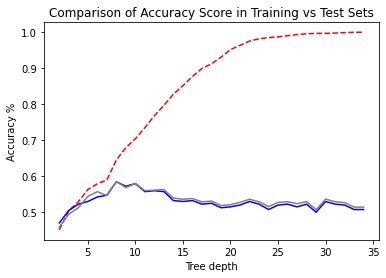

In [292]:
depths = [n for n in range(2, 35)]
training_score= []
testing_score=[]
b_testing_score=[]

for val in depths: 
    dtree = DecisionTreeClassifier(criterion='gini', max_depth = val, random_state=123)
    dtree.fit(X_tr_scaled, y_tr)
    
    y_train_pred = dtree.predict(X_tr_scaled)
    y_test_pred = dtree.predict(X_te_scaled)
    
    training_score.append(metrics.accuracy_score(y_tr ,y_train_pred))
    testing_score.append(metrics.accuracy_score(y_te ,y_test_pred))
    b_testing_score.append(metrics.balanced_accuracy_score(y_te,y_test_pred))

plt.plot(depths, training_score, linestyle='dashed', color='red')
plt.plot(depths, testing_score, linestyle='solid', color='blue')
plt.plot(depths, b_testing_score, linestyle='solid', color='grey')
plt.title('Comparison of Accuracy Score in Training vs Test Sets')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy %')
plt.show()

In [293]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', 8)

Decision Tree model - gini criterion, max depth: 8
Accuracy (train): 	 0.6453
Accuracy (test): 	 0.5846
Balanced accuracy:	 0.5850
Classification report: 
               precision    recall  f1-score   support

           $       0.88      0.77      0.82        98
          $$       0.61      0.24      0.35       103
         $$$       0.42      0.72      0.53       111
        $$$$       0.63      0.61      0.62        90

    accuracy                           0.58       402
   macro avg       0.64      0.58      0.58       402
weighted avg       0.63      0.58      0.58       402



*Observations*
- Based on the visualisation above, the better model uses a gini criterion with a max depth of 8 layers. 
- Performance-wise, however, the lift is not significant. 

In [294]:
dtree2 = DecisionTreeClassifier(criterion='gini', max_depth = 8, random_state=123)
dtree2.fit(X_tr_scaled, y_tr)

DecisionTreeClassifier(max_depth=8, random_state=123)

In [295]:
y_tr_pred = dtree.predict(X_tr_scaled)
y_te_pred = dtree.predict(X_te_scaled)

In [296]:
dot_data = StringIO()

#Create DOT data 
tree.export_graphviz(dtree2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=X_tr_scaled.columns,
                class_names = ['£','££', '£££', '££££']
                ) 

#Draw graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Show graph
Image(graph.create_png())

#Save to file 
graph.write_png('decisiontree.png')

True

#### Insights from the model

- Useful features: Product type, specific brands, number of likes 
- To some extent, richness, number of reviews, DullnessUneven, clean@sephora

#### Retain the tree model using selected features

*Can we increase model performance using the feature selection from other models?*

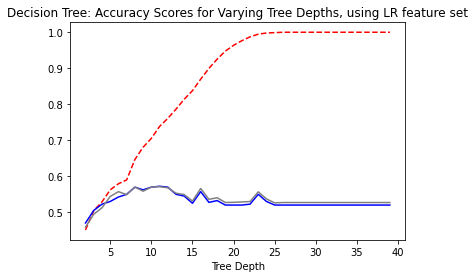

In [297]:
#Using features from logistic regression 

#Also determine the optimal depth for the tree
depths = [n for n in range(2, 40)]
training_score= []
testing_score=[]
b_testing_score=[]

for val in depths: 
    dtree = DecisionTreeClassifier(criterion='gini', max_depth = val, random_state=123)
    dtree.fit(X_tr_select, y_tr)
    
    #we use non-scaled set here
    y_train_pred = dtree.predict(X_tr_select)
    y_test_pred = dtree.predict(X_te_select)
    
    training_score.append(metrics.accuracy_score(y_tr ,y_train_pred))
    testing_score.append(metrics.accuracy_score(y_te ,y_test_pred))
    b_testing_score.append(metrics.balanced_accuracy_score(y_te,y_test_pred))

plt.plot(depths, training_score, linestyle='dashed', color='red')
plt.plot(depths, testing_score, linestyle='solid', color='blue')
plt.plot(depths, b_testing_score, linestyle='solid', color='grey')
plt.title('Decision Tree: Accuracy Scores for Varying Tree Depths, using LR feature set')
plt.xlabel('Tree Depth')
plt.show()

In [298]:
tempdt = pd.DataFrame({'depth': depths, 'training_score': training_score, 'testing_score': testing_score})
tempdt[tempdt.testing_score==tempdt.testing_score.max()]

depth  training_score  testing_score
9     11        0.738248       0.572139

In [299]:
dtree_lgfeatures = DecisionTreeClassifier(criterion='gini', max_depth = 11, random_state=123)

In [300]:
dtree_lgfeatures.fit(X_tr_select, y_tr)
y_tr_pred = dtree_lgfeatures.predict(X_tr_select)
y_te_pred = dtree_lgfeatures.predict(X_te_select)

In [302]:
#Check accuracy 
eval_model(dtree_lgfeatures, X_tr_select, y_tr, 5, scores_list, 'DT - scaled and chosen from LR set, with max depth', True, True)

DT - scaled and chosen from LR set, with max depth

Test scores: (mean, SD)
 Accuracy: 
 (0.5384, 0.0215)
 F1_Weighted: 
 (0.5443, 0.0218)
 Precision_Weighted: 
 (0.5745, 0.0395)
 Recall_Weighted: 
 (0.5384, 0.0215)

Training scores:
 Accuracy: 
 (0.7521, 0.0078)
 F1_Weighted: 
 (0.7594, 0.007)
 Precision_Weighted: 
 (0.7971, 0.0193)
 Recall_Weighted: 
 (0.7521, 0.0078)


In [303]:
#Evaluate model
decision_tree(X_tr_select, X_te_select, y_tr, y_te, 'gini', 11)

Decision Tree model - gini criterion, max depth: 11
Accuracy (train): 	 0.7382
Accuracy (test): 	 0.5721
Balanced accuracy:	 0.5710
Classification report: 
               precision    recall  f1-score   support

           $       0.81      0.79      0.80        98
          $$       0.55      0.23      0.33       103
         $$$       0.42      0.72      0.53       111
        $$$$       0.69      0.54      0.61        90

    accuracy                           0.57       402
   macro avg       0.62      0.57      0.57       402
weighted avg       0.61      0.57      0.56       402



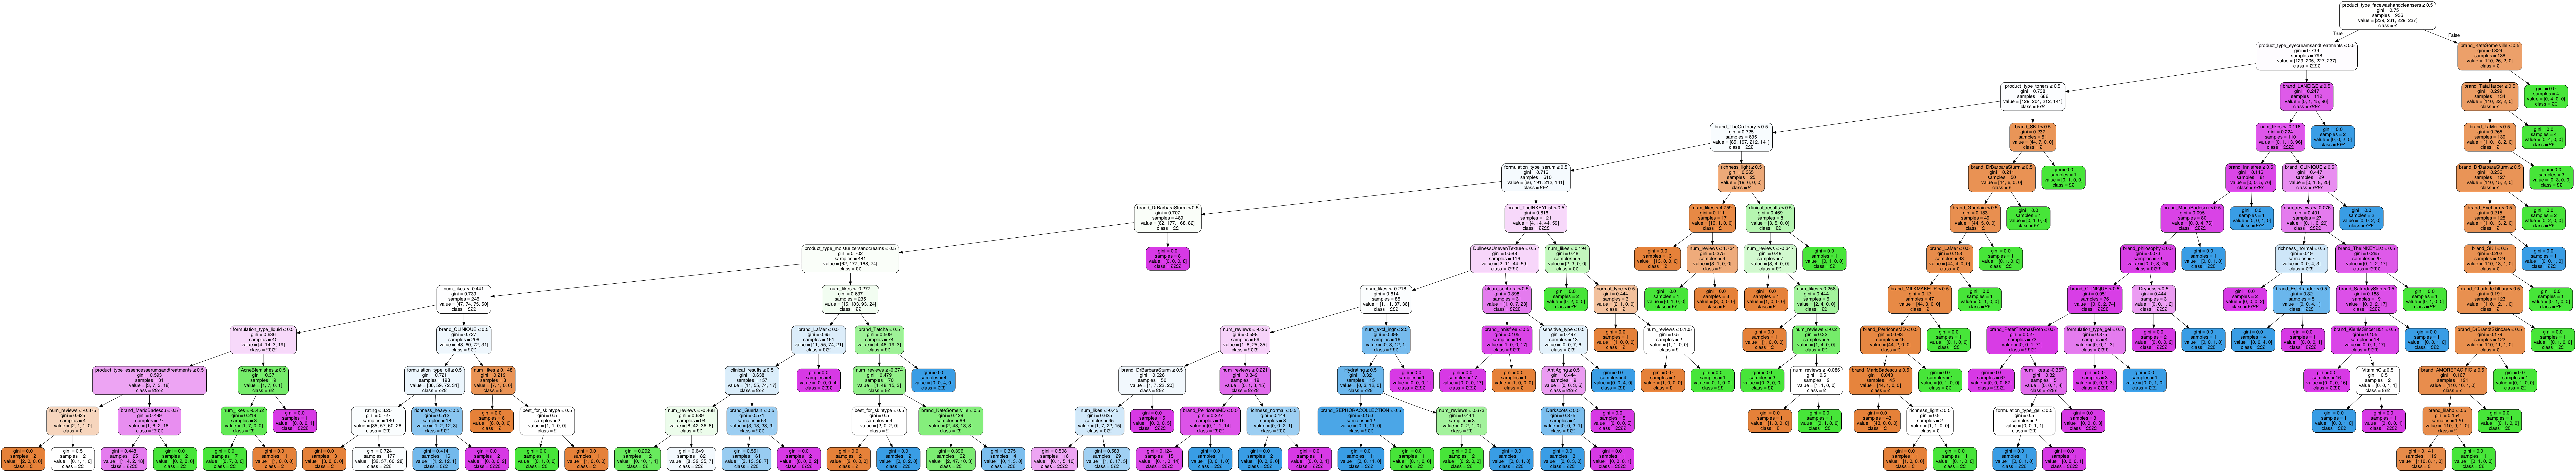

In [304]:
dot_data2 = StringIO()

tree.export_graphviz(dtree_lgfeatures, out_file=dot_data2,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=X_tr_select.columns,
                class_names = ['£','££', '£££', '££££']
                ) 

graph = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
#graph.write_pdf('tree.pdf')
Image(graph.create_png())

## 3.1 Ensemble models

### RandomForest Model

In [305]:
#First try the default settings for RF
rf = RandomForestClassifier(random_state = 123, n_jobs=-1)

In [306]:
eval_model(rf, X_tr, y_tr, 5, scores_list, 'RandomForest - no max depth', True)

RandomForest - no max depth

Test scores: (mean, SD)
 Accuracy: 
 (0.6175, 0.032)
 F1_Weighted: 
 (0.6118, 0.0331)
 Precision_Weighted: 
 (0.6129, 0.0327)
 Recall_Weighted: 
 (0.6175, 0.032)

Training scores:
 Accuracy: 
 (1.0, 0.0)
 F1_Weighted: 
 (1.0, 0.0)
 Precision_Weighted: 
 (1.0, 0.0)
 Recall_Weighted: 
 (1.0, 0.0)


*Using the default parameters, it will overfit as we did not set a max depth.*

**Imposing max depth on the RandomForest Model**

In [307]:
rf_criterion='entropy' #default: gini
estimators= 100
rf_depth=6
rf2= RandomForestClassifier(n_estimators = estimators, criterion = rf_criterion,   
                            max_depth= rf_depth, random_state = 123, n_jobs=-1)

In [308]:
rf2.fit(X_tr, y_tr)
y_tr_pred= rf2.predict(X_tr)
y_te_pred= rf2.predict(X_te)

In [311]:
#Since RF is not distance based, we can try non-scaled 
eval_model(rf2, X_tr, y_tr, 5, scores_list, 'RandomForest model - max depth imposed', True, True)

RandomForest model - max depth imposed

Test scores: (mean, SD)
 Accuracy: 
 (0.6004, 0.0396)
 F1_Weighted: 
 (0.5902, 0.042)
 Precision_Weighted: 
 (0.5888, 0.0428)
 Recall_Weighted: 
 (0.6004, 0.0396)

Training scores:
 Accuracy: 
 (0.7676, 0.0102)
 F1_Weighted: 
 (0.7648, 0.0101)
 Precision_Weighted: 
 (0.7668, 0.0108)
 Recall_Weighted: 
 (0.7676, 0.0102)


Accuracy score on test: 0.6019900497512438
Average ROC AUC score: 0.7392
{'$': 0.8488, '$$$$': 0.7922, '$$': 0.6644, '$$$': 0.6513}
Classification report: 
               precision    recall  f1-score   support

           $       0.71      0.81      0.75        98
          $$       0.54      0.47      0.50       103
         $$$       0.54      0.45      0.49       111
        $$$$       0.60      0.72      0.66        90

    accuracy                           0.60       402
   macro avg       0.60      0.61      0.60       402
weighted avg       0.59      0.60      0.59       402

Confusion matrix, without normalization:
[[79 14  5  0]
 [24 48 22  9]
 [ 6 21 50 34]
 [ 3  6 16 65]]
Normalized confusion matrix:
[[0.81 0.14 0.05 0.  ]
 [0.23 0.47 0.21 0.09]
 [0.05 0.19 0.45 0.31]
 [0.03 0.07 0.18 0.72]]


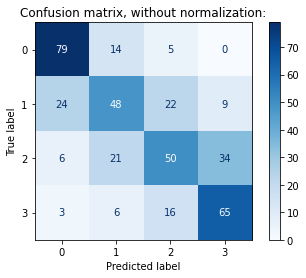

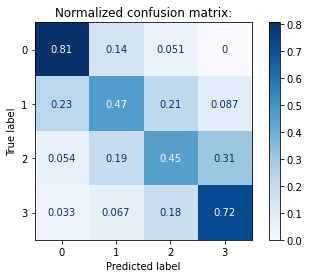

In [382]:
evaluate_test(rf2, X_tr, X_te, y_tr, y_te, 'RandomForest model - max depth imposed', True)

**Visualizing the tree**

*Which feature are predictive of pricing?*

In [ ]:
# estimator = rf2.estimators_[5]
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = X_tr_scaled.columns,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

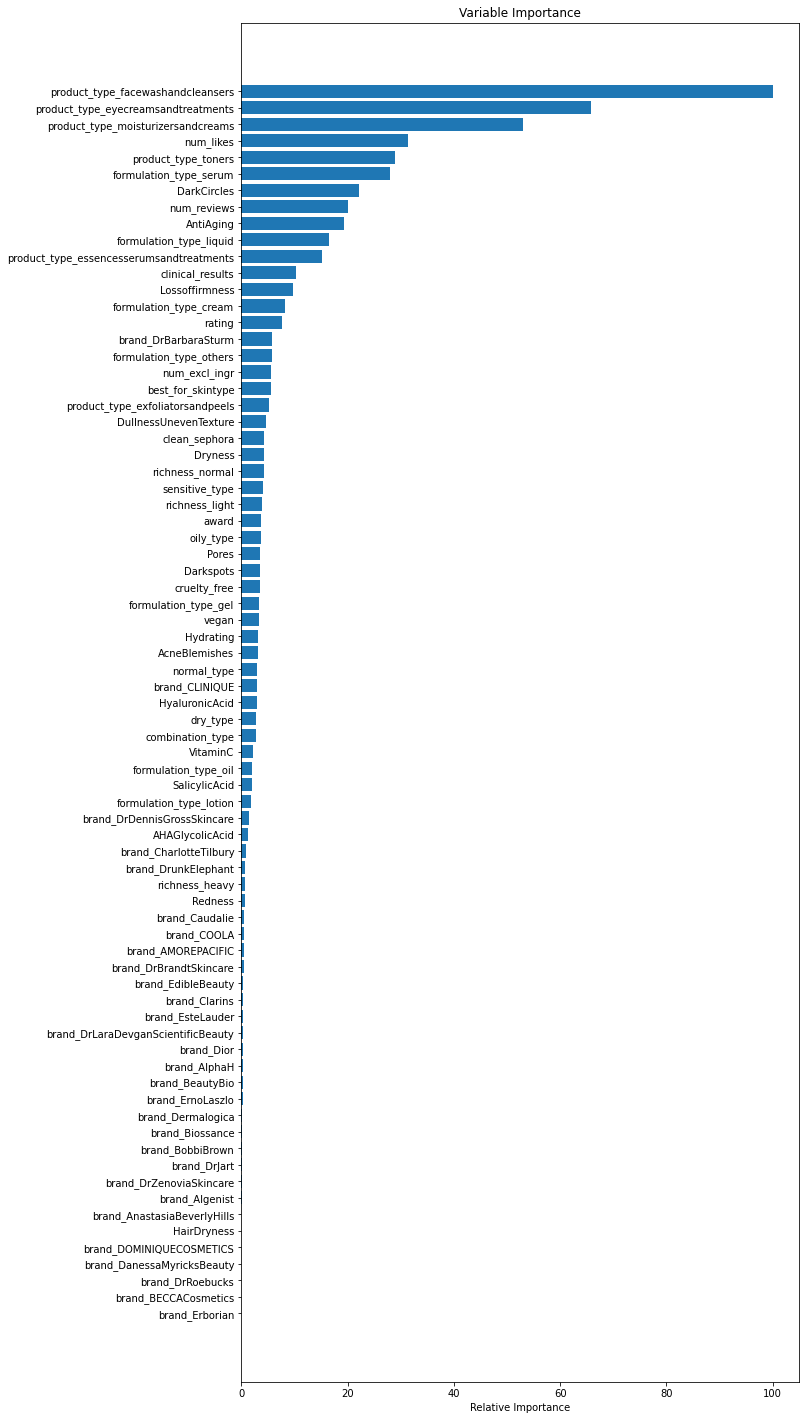

In [314]:
feature_importances = rf2.feature_importances_
# make importances relative to max importance
feature_importances = 100.0 * (feature_importances / feature_importances.max())[:75]
sorted_idx = np.argsort(feature_importances)[:75]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,25))
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<font color='red'> TBD: Whilst there is some overlap in the top features, there are also noticeable differences -i.e. number of likes, reviews are more important in this model. Generally, it looks like the brands were not as high of predictors as the basic product information. interesting finding! 

- makes sense for Rf to make predictions like this actually </font>

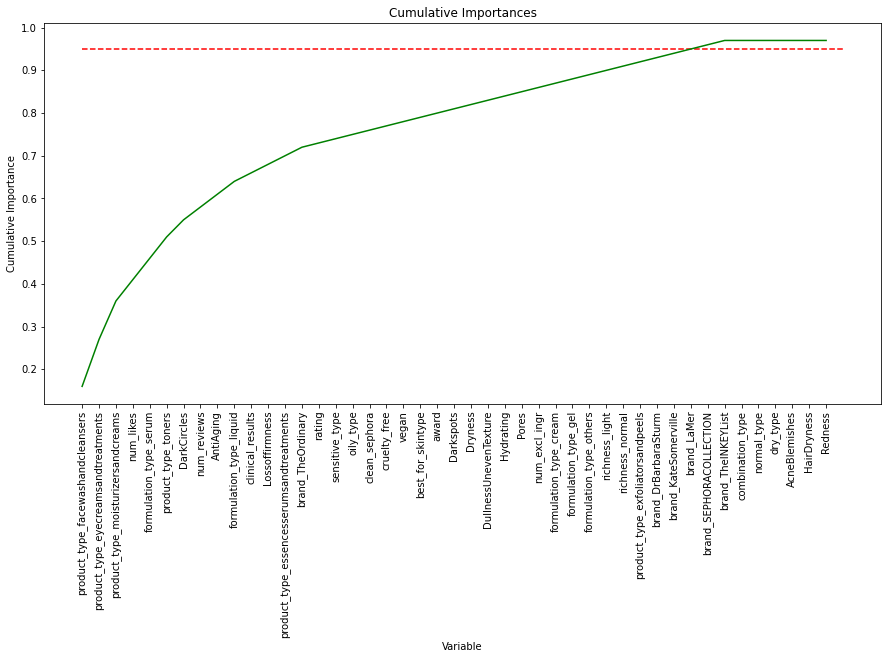

In [315]:
#How many features are important? 

feat_list =[(feature, round(feature_importance, 2))
    for feature, feature_importance in zip(X_tr.columns, rf2.feature_importances_.tolist())]
feat_list = sorted(feat_list, key = lambda x:x[1], reverse=True)[:45]
x_values = list(range(45))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feat_list]
sorted_features = [importance[0] for importance in feat_list]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.figure(figsize=(15,7))
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Importances');
plt.show()

In [316]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feat_list[0:38]]
important_feature_names

['product_type_facewashandcleansers',
 'product_type_eyecreamsandtreatments',
 'product_type_moisturizersandcreams',
 'num_likes',
 'formulation_type_serum',
 'product_type_toners',
 'DarkCircles',
 'num_reviews',
 'AntiAging',
 'formulation_type_liquid',
 'clinical_results',
 'Lossoffirmness',
 'product_type_essencesserumsandtreatments',
 'brand_TheOrdinary',
 'rating',
 'sensitive_type',
 'oily_type',
 'clean_sephora',
 'cruelty_free',
 'vegan',
 'best_for_skintype',
 'award',
 'Darkspots',
 'Dryness',
 'DullnessUnevenTexture',
 'Hydrating',
 'Pores',
 'num_excl_ingr',
 'formulation_type_cream',
 'formulation_type_gel',
 'formulation_type_others',
 'richness_light',
 'richness_normal',
 'product_type_exfoliatorsandpeels',
 'brand_DrBarbaraSturm',
 'brand_KateSomerville',
 'brand_LaMer',
 'brand_SEPHORACOLLECTION']

Create a new training set based on features selected using RF

In [317]:
X_tr_selectrf = X_tr.loc[:, important_feature_names].copy()
X_te_selectrf = X_te.loc[:, important_feature_names].copy()

X_tr_sc_selectrf = X_tr_scaled.loc[:, important_feature_names].copy()
X_te_sc_selectrf = X_te_scaled.loc[:, important_feature_names].copy()

**Optimize the RandomForest model using GridSearch**

Selected parameters to tune for RF:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

Leveraging on Bayesian Optimization

https://pierpaolo28.github.io/blog/blog25/#automated-hyperparameter-tuning

In [318]:
#! pip install hyperopt

In [319]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 random_state=12)
    
    accuracy = cross_val_score(model, 
                               #X_tr_select_rf, 
                               X_tr,
                               y_tr, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

  1%|▏         | 1/80 [00:04<05:53,  4.47s/trial, best loss: -0.25213675213675213]


KeyboardInterrupt: 

In [320]:
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 3000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 1100, num = 100)]
max_depth.append(None)
min_samples_split = [2, 60, 75, 90]
min_samples_leaf = [0, 1, 3, 5, 7]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [322]:
rf_search_bayes = RandomForestClassifier(random_state = 123, n_jobs=-1)
rf_cv= RandomizedSearchCV(rf_search_bayes, random_grid, cv=5, n_iter=5, random_state=123)
rf_cv.fit(X_tr,y_tr)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=123),
                   n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 109, 120, 131,
                                                      142, 153, 164, 175, 186,
                                                      197, 208, 219, 230, 241,
                                                      252, 263, 274, 285, 296,
                                                      307, 318, 329, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0, 1, 3, 5, 7],
                                        'min_samples_split': [2, 60, 75, 90],
                                        'n_e

In [323]:
rf_cv.best_score_

0.6015018773466834

In [324]:
bestrf = rf_cv.best_params_

In [325]:
rf_opt_bayes= RandomForestClassifier(n_estimators=bestrf['n_estimators'], 
                                     min_samples_split= bestrf['min_samples_split'], 
                                     min_samples_leaf= bestrf['min_samples_leaf'],
                                     max_features=bestrf['max_features'], 
                                     max_depth= bestrf['max_depth'], 
                                     bootstrap=bestrf['bootstrap'], 
                                     random_state=123)

In [326]:
rf_opt_bayes.fit(X_tr, y_tr)
y_tr_pred = rf_opt_bayes.predict(X_tr)
y_te_pred = rf_opt_bayes.predict(X_te)

In [327]:
eval_model(rf_opt_bayes, X_tr, y_tr, 5, scores_list, 'RF - unscaled training set, tuned parameters', True)

RF - unscaled training set, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6015, 0.033)
 F1_Weighted: 
 (0.5898, 0.0342)
 Precision_Weighted: 
 (0.5887, 0.0356)
 Recall_Weighted: 
 (0.6015, 0.033)

Training scores:
 Accuracy: 
 (0.7687, 0.014)
 F1_Weighted: 
 (0.765, 0.0144)
 Precision_Weighted: 
 (0.769, 0.0137)
 Recall_Weighted: 
 (0.7687, 0.014)


*Model performance is not as good as SVM and logistic regression*

*Can we increase RF model performance by using a selected feature set?*
- not expecting an improvement as RF is able to deal with many features anyway

In [330]:
eval_model(rf_opt_bayes, X_tr_select, y_tr, 5, scores_list, 'RF - unscaled training set, selected LR features, tuned parameters', True)

RF - unscaled training set, selected LR features, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6015, 0.027)
 F1_Weighted: 
 (0.5894, 0.0283)
 Precision_Weighted: 
 (0.5893, 0.0301)
 Recall_Weighted: 
 (0.6015, 0.027)

Training scores:
 Accuracy: 
 (0.7567, 0.0104)
 F1_Weighted: 
 (0.7523, 0.0111)
 Precision_Weighted: 
 (0.7565, 0.0104)
 Recall_Weighted: 
 (0.7567, 0.0104)


## 4.3 Other

## GradientBoosting

In [331]:
param={
    'loss':['deviance', 'exponential'],
    'n_estimators':[50, 100, 150, 250],
    'max_depth': [3, 7, 11, 15],
    'learning_rate':[0.01, 0.1, 0.25, 0.5, 0.75, 1],
    'subsample':[0.5, 1],
    'min_samples_split':[4, 7, 10],
    'min_samples_leaf': [5, 10, 20]
}

gb= GradientBoostingClassifier(random_state=123)
gb_gs=RandomizedSearchCV(gb, param, cv=5, n_jobs=-1, random_state=123)
cv_fit= gb_gs.fit(X_tr, y_tr)

In [332]:
gb_search_results= pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)
gb_search_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2       1.839650      0.106485         0.011664        0.002876   
5       1.770656      0.149719         0.006240        0.001184   
4       2.868123      0.117297         0.010385        0.003080   
0       0.010302      0.002659         0.000000        0.000000   
1       0.006106      0.001304         0.000000        0.000000   

  param_subsample param_n_estimators param_min_samples_split  \
2             0.5                100                       4   
5               1                 50                      10   
4             0.5                250                       7   
0               1                150                       4   
1             0.5                250                      10   

  param_min_samples_leaf param_max_depth   param_loss param_learning_rate  \
2                     20              11     deviance                0.25   
5                     20              11     deviance                   1   
4                     10               3     deviance                 0.5   
0                     20              15  exponential                   1   
1                     20              15  exponential                   1   

                                              params  split0_test_score  \
2  {'subsample': 0.5, 'n_estimators': 100, 'min_s...           0.537234   
5  {'subsample': 1, 'n_estimators': 50, 'min_samp...           0.526596   
4  {'subsample': 0.5, 'n_estimators': 250, 'min_s...           0.489362   
0  {'subsample': 1, 'n_estimators': 150, 'min_sam...                NaN   
1  {'subsample': 0.5, 'n_estimators': 250, 'min_s...                NaN   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
2           0.529412           0.582888           0.518717           0.566845   
5           0.529412           0.556150           0.470588           0.561497   
4           0.497326           0.572193           0.529412           0.534759   
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   

   mean_test_score  std_test_score  rank_test_score  
2         0.547019        0.024027                1  
5         0.528849        0.032283                2  
4         0.524610        0.029587                3  
0              NaN             NaN                4  
1              NaN             NaN                5

In [337]:
gb1 = GradientBoostingClassifier(subsample= 0.5,n_estimators= 100, min_samples_split=4, min_samples_leaf= 20,
                                max_depth= 11, loss='deviance', learning_rate=0.25, random_state=123)

In [338]:
gb1.fit(X_tr, y_tr)
y_tr_pred = gb1.predict(X_tr)
y_te_pred = gb1.predict(X_te)

In [341]:
eval_model(gb1, X_tr, y_tr, 5, scores_list, 'GB - unscaled training set, tuned parameters', True, True)

GB - unscaled training set, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.547, 0.024)
 F1_Weighted: 
 (0.5468, 0.0259)
 Precision_Weighted: 
 (0.5487, 0.0289)
 Recall_Weighted: 
 (0.547, 0.024)

Training scores:
 Accuracy: 
 (0.9944, 0.001)
 F1_Weighted: 
 (0.9944, 0.001)
 Precision_Weighted: 
 (0.9944, 0.001)
 Recall_Weighted: 
 (0.9944, 0.001)


<font color='red'> High tendency to overfit! how do you control overfitting </font>

In [335]:
#Create a gb model with parameters tuned to reduce overfitting
gb = GradientBoostingClassifier(subsample= 1,n_estimators= 250, min_samples_split=10, min_samples_leaf= 5,
                                max_depth= 3, loss='deviance', learning_rate=0.01, random_state=123)

In [336]:
gb.fit(X_tr, y_tr)
y_tr_pred = gb.predict(X_tr)
y_te_pred = gb.predict(X_te)

In [342]:
eval_model(gb, X_tr, y_tr, 5, scores_list, 'GB - unscaled training set, tuned parameters to reduce overfitting', True, True)

GB - unscaled training set, tuned parameters to reduce overfitting

Test scores: (mean, SD)
 Accuracy: 
 (0.5897, 0.0212)
 F1_Weighted: 
 (0.5919, 0.023)
 Precision_Weighted: 
 (0.6003, 0.0283)
 Recall_Weighted: 
 (0.5897, 0.0212)

Training scores:
 Accuracy: 
 (0.7059, 0.0105)
 F1_Weighted: 
 (0.7075, 0.0102)
 Precision_Weighted: 
 (0.7153, 0.0065)
 Recall_Weighted: 
 (0.7059, 0.0105)


Accuracy score on test: 0.6243781094527363
Average ROC AUC score: 0.7517
{'$': 0.8782, '$$$$': 0.7876, '$$': 0.6772, '$$$': 0.6637}
Classification report: 
               precision    recall  f1-score   support

           $       0.87      0.80      0.83        98
          $$       0.54      0.50      0.52       103
         $$$       0.49      0.54      0.52       111
        $$$$       0.66      0.68      0.67        90

    accuracy                           0.62       402
   macro avg       0.64      0.63      0.63       402
weighted avg       0.63      0.62      0.63       402

Confusion matrix, without normalization:
[[78 11  7  2]
 [10 52 33  8]
 [ 1 28 60 22]
 [ 1  6 22 61]]
Normalized confusion matrix:
[[0.8  0.11 0.07 0.02]
 [0.1  0.5  0.32 0.08]
 [0.01 0.25 0.54 0.2 ]
 [0.01 0.07 0.24 0.68]]


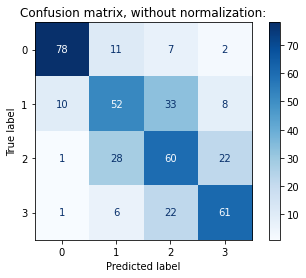

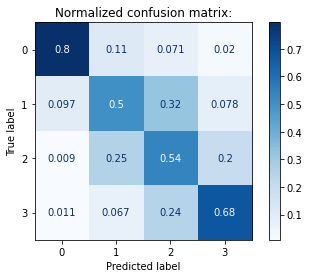

In [383]:
evaluate_test(gb, X_tr, X_te, y_tr, y_te, 'GB - unscaled training set, tuned parameters to reduce overfitting', True)

How does Gradient Boosting make its predictions? Which features are most important?

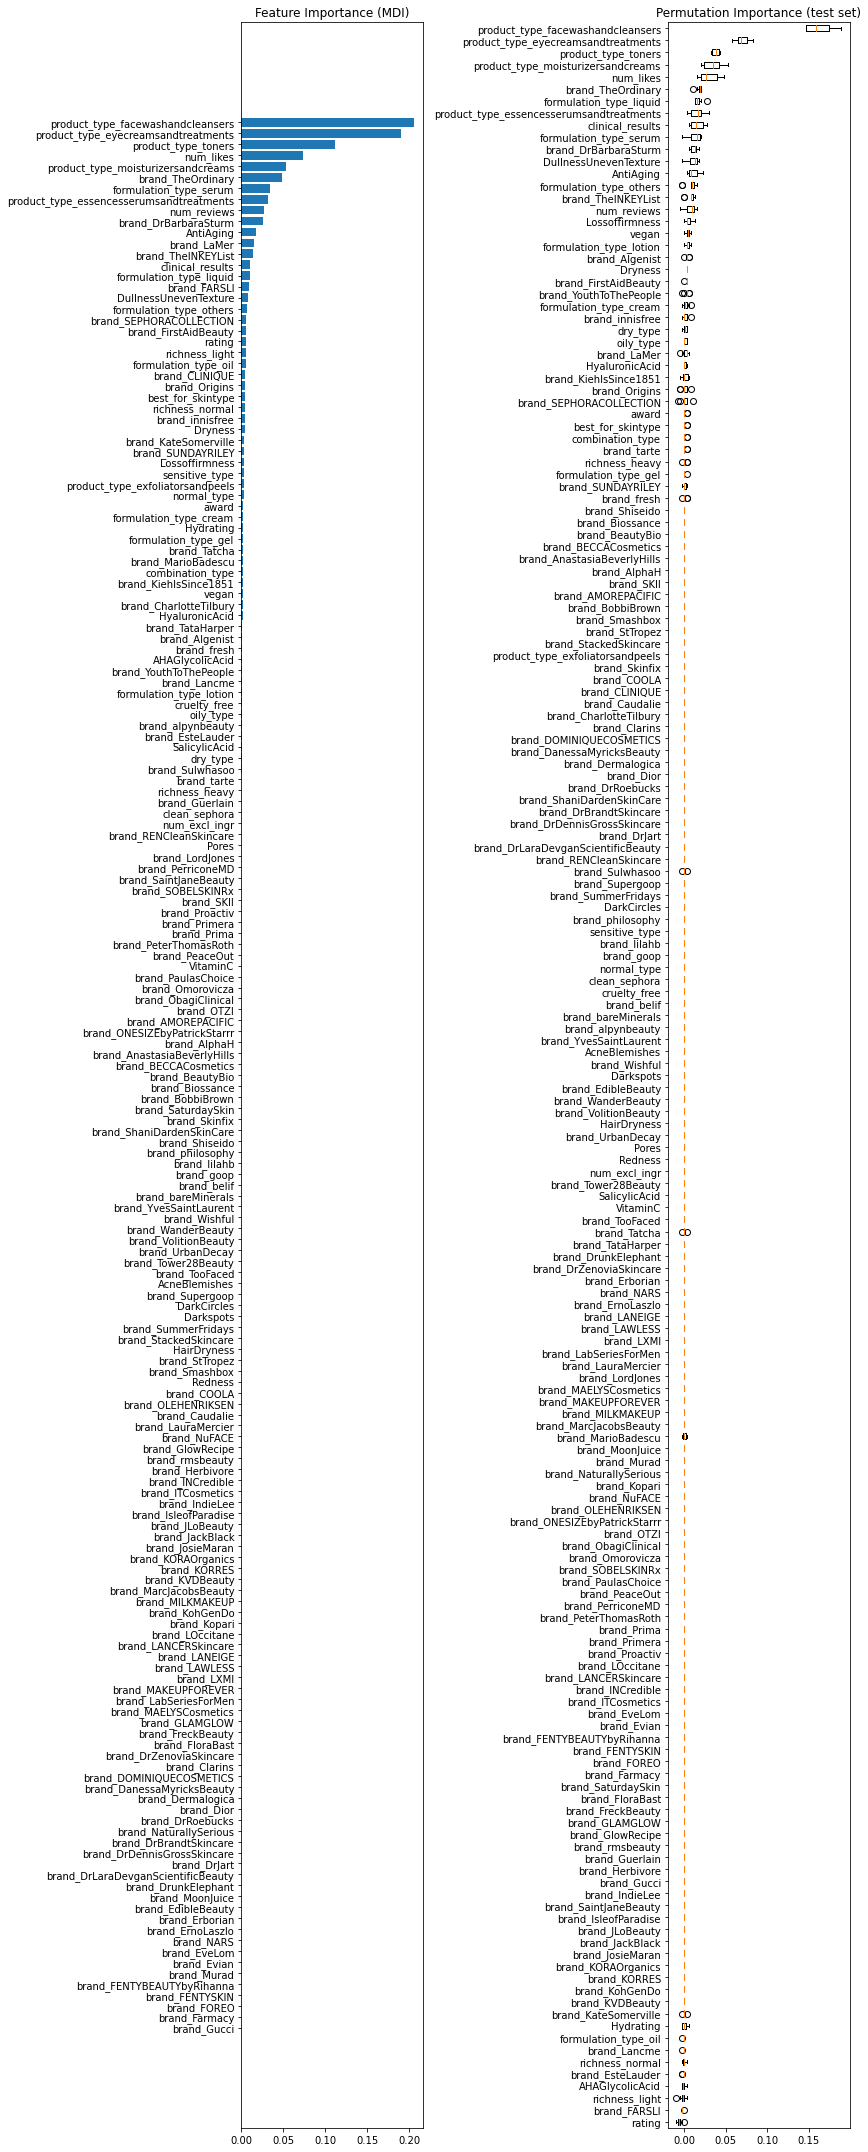

In [343]:
from sklearn.inspection import permutation_importance
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 30))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_tr.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(gb, X_te, y_te, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X_tr.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

<font color='red'> interesting results - it looks like a combination of rf selected features + LR/SVM important features!

In [ ]:
# import eli5
# from eli5.sklearn import PermutationImportance

# def get_feature_importance(model, X, y, feature_names):
#     perm = PermutationImportance(model, random_state=42).fit(X, y)
#     return eli5.show_weights(perm, feature_names=feature_names)

# show_weights(result, feature_names= X_tr.columns)


# get_feature_importance(trained_model, X_test, y_test, feature_names)

### XGBoost

In [ ]:
#! pip install xgboost

In [ ]:
#! brew install libomp

In [344]:
#XGBoost only accepts numerical values
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_tr)
y_tr_num = label_encoder.transform(y_tr)
y_te_num = label_encoder.transform(y_te)

In [345]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = RandomizedSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=5,
                    random_state=123)

grid.fit(X_tr, y_tr_num)

[08:59:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [346]:
bestgb= grid.best_params_
bestgb

{'min_child_weight': 5,
 'max_depth': 3,
 'gamma': 0.2,
 'eta': 0.15,
 'colsample_bytree': 0.4}

In [458]:
#Build xgb model with tuned parameters
xgb_opt = xgb.XGBClassifier(min_child_weight= bestgb['min_child_weight'], 
                            max_depth= bestgb['max_depth'], 
                            gamma= bestgb['gamma'], 
                            eta= bestgb['eta'], 
                            colsample_bytree= bestgb['colsample_bytree'])

In [360]:
eval_model(xgb_opt, X_tr, y_tr_num, 5, scores_list, 'XGBoost - unscaled training set, tuned parameters', True, True)

[09:08:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:08:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[09:17:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on test: 0.6069651741293532
Average ROC AUC score: 0.7418
{0: 0.8685, 1: 0.6514, 2: 0.6453, 3: 0.8018}
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        98
           1       0.52      0.45      0.48       103
           2       0.49      0.49      0.49       111
           3       0.64      0.72      0.68        90

    accuracy                           0.61       402
   macro avg       0.61      0.62      0.61       402
weighted avg       0.60      0.61      0.60       402

Confusion matrix, without normalization:
[[79 12  7  0]
 [16 46 33  8]
 [ 4 24 54 29]
 [ 1  7 17 65]]
Normalized confusion matrix:
[[0.81 0

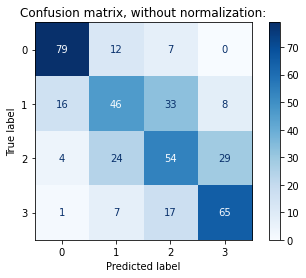

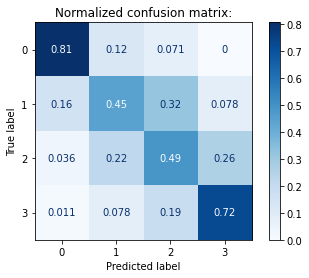

KeyError: '$'

In [384]:
evaluate_test(xgb_opt, X_tr, 
              y_tr_num, y_te_num, 'XGBoost - unscaled training set, tuned parameters', True)

<font color='red'> wondering if this is all for the ensemble models - i.e. gridsearch + modelling as usual? </font>

Which features are important in the XGBoost model?

Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.

The feature importances are then averaged across all of the the decision trees within the model.

[08:59:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


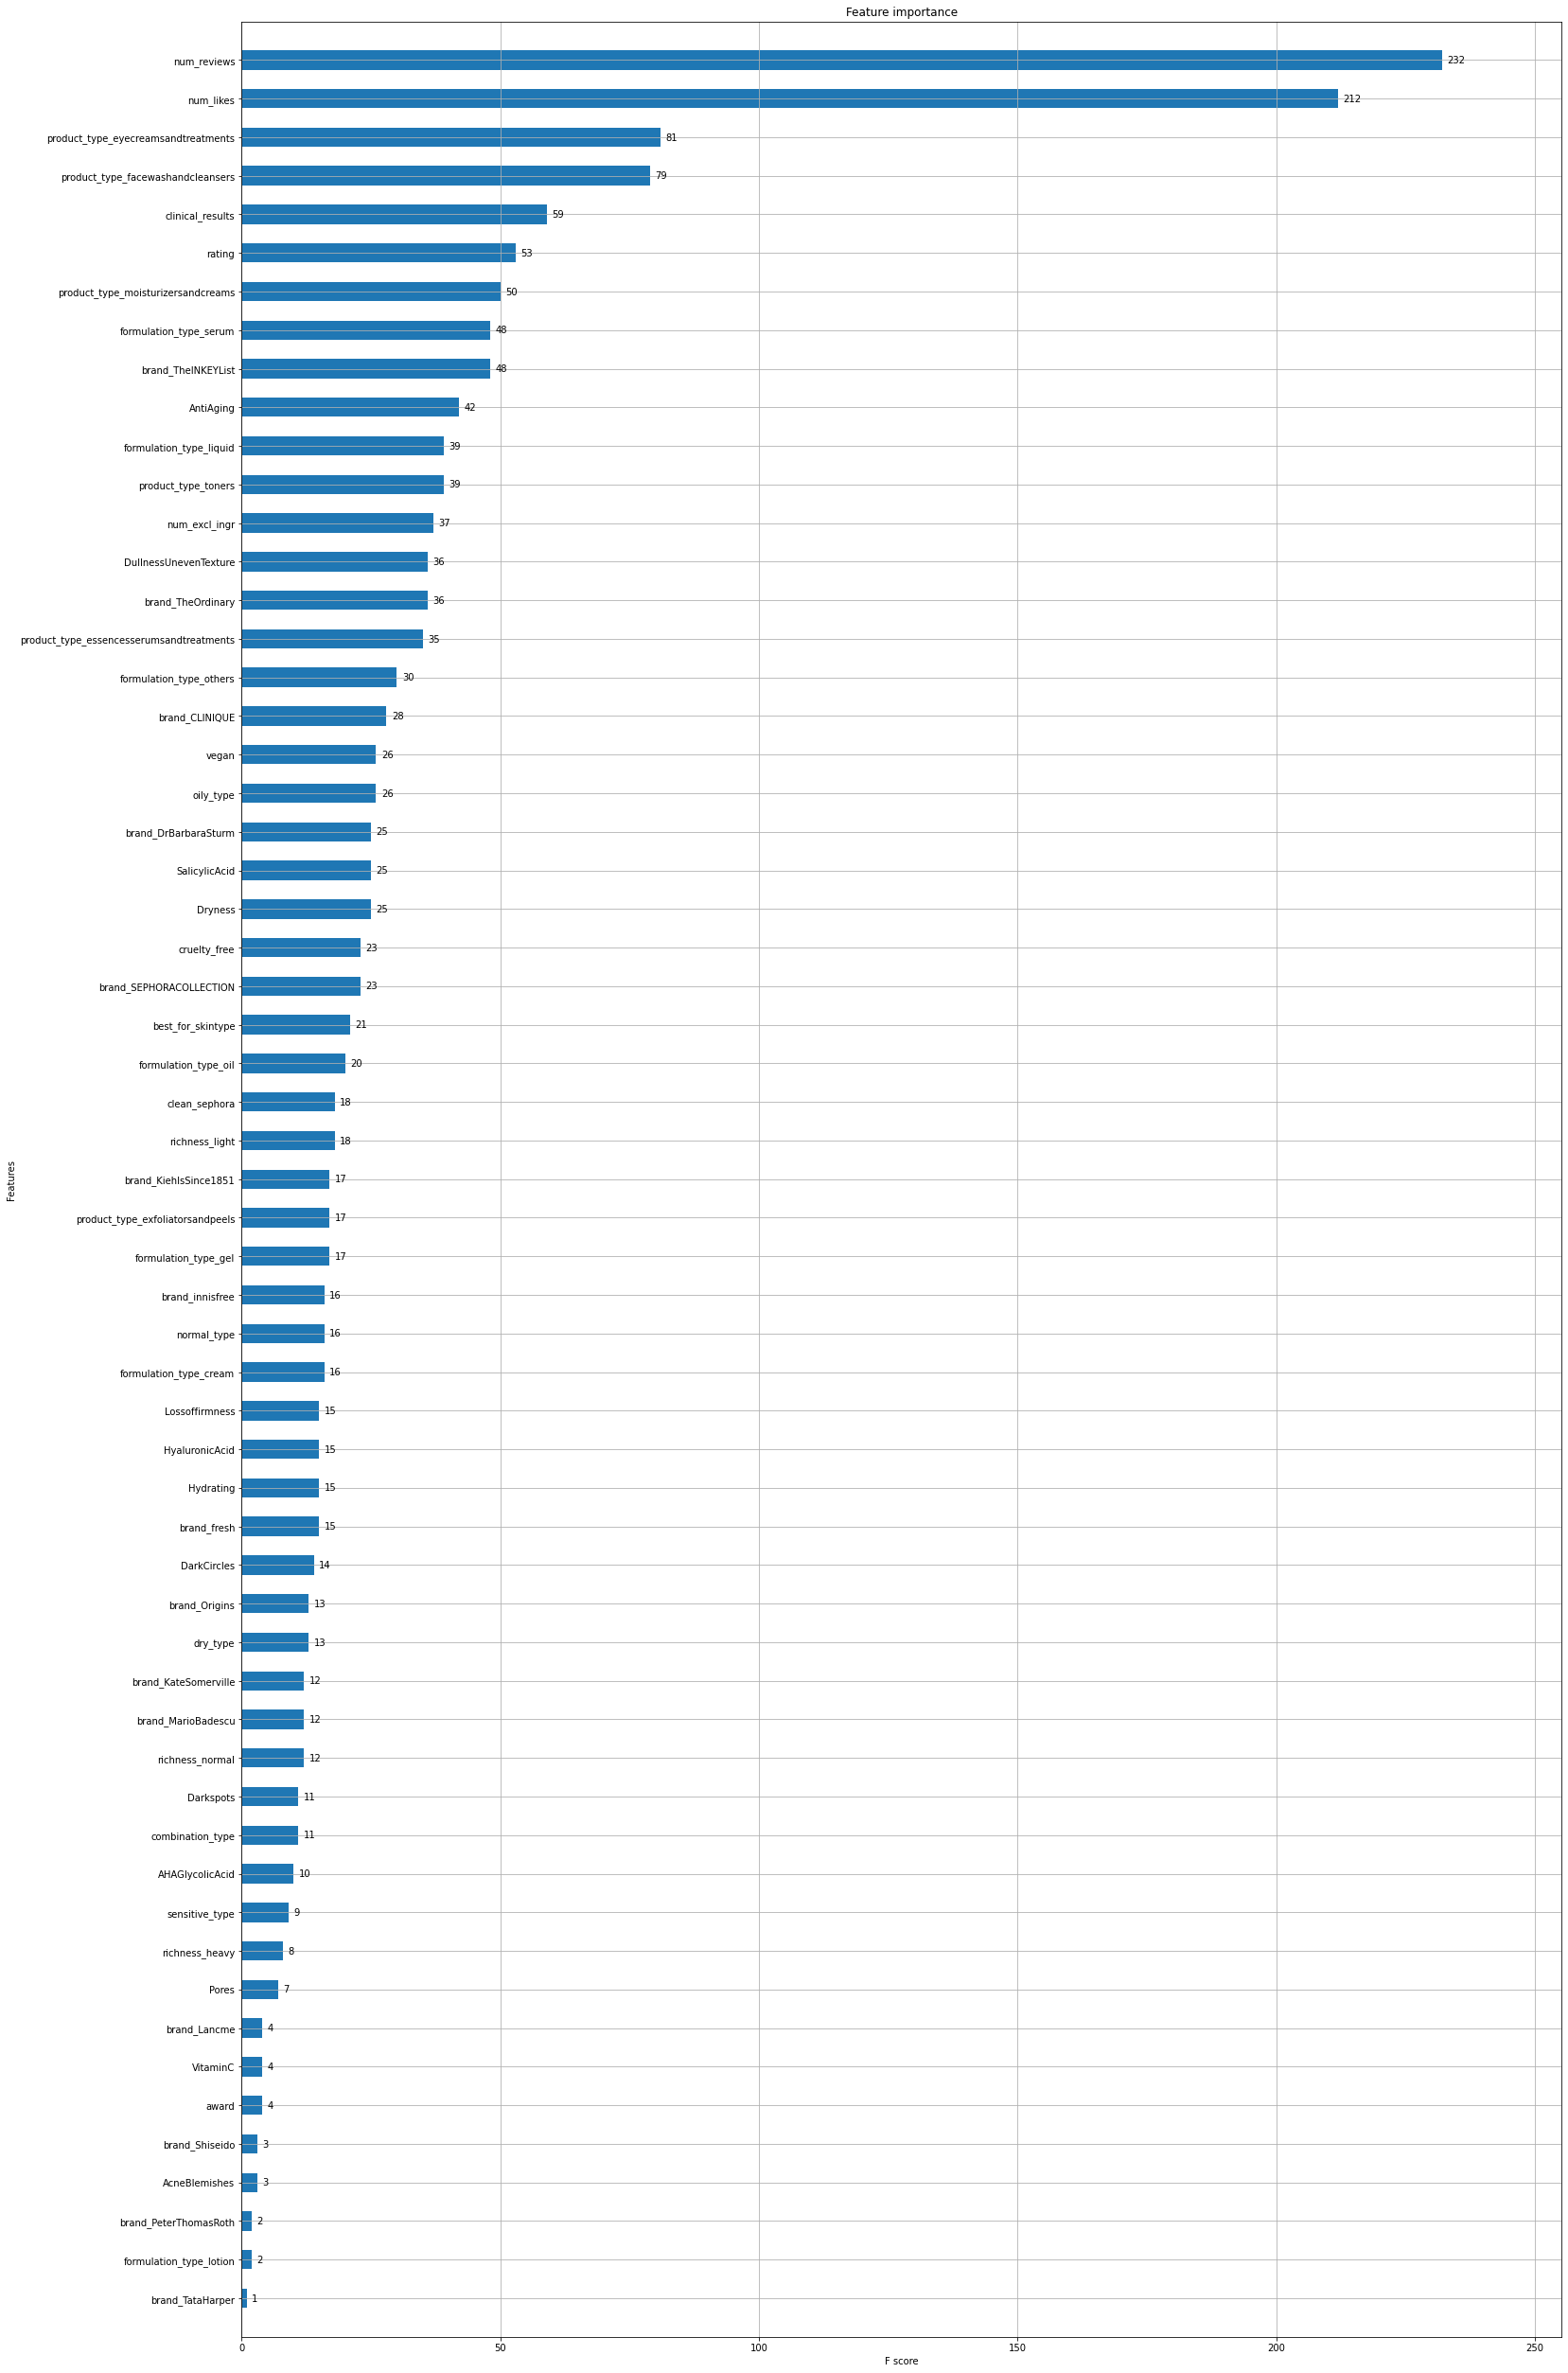

In [349]:
from xgboost import plot_importance
xgb_opt.fit(X_tr,y_tr_num)
ax= plot_importance(xgb_opt, max_num_features=100, height=0.5)
fig = ax.figure
fig.set_size_inches(25, 45)
plt.show();

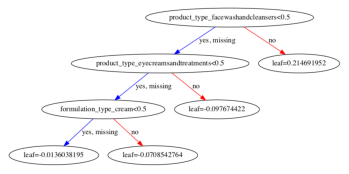

In [354]:
# from xgboost import plot_tree
# plot_tree(xgb_opt)
# plt.show()

In [359]:
#xgb.to_graphviz(xgb_opt, num_trees=21, rankdir='LR')

## 5.0 Reviewing the results

In [368]:
#Evaluation using cross validated measures only
model_cv = pd.DataFrame(cv_records).sort_values(by='Accuracy (CV test) mean', ascending=False)
model_cv

Description  \
5   SVM - scaled training set, selected features u...   
4   SVM - scaled training set, selected features u...   
6         LR - SVM feature set, tuned hyperparameters   
1          LR - scaled training set, tuned parameters   
0               LR - scaled training set, base (saga)   
8              RandomForest model - max depth imposed   
2            LR - PCA scaled training set, base model   
3            LR - PCA scaled training set, base model   
10  GB - unscaled training set, tuned parameters t...   
11  XGBoost - unscaled training set, tuned parameters   
9        GB - unscaled training set, tuned parameters   
7   DT - scaled and chosen from LR set, with max d...   

    Accuracy (CV test) mean  Accuracy (CV test) std  Accuracy (CV train) mean  \
5                  0.657083                0.040345                  0.726231   
4                  0.636745                0.023773                  0.727032   
6                  0.633548                0.032879                  0.753205   
1                  0.631409                0.046380                  0.845888   
0                  0.630288                0.041474                  0.785253   
8                  0.600444                0.039607                  0.767628   
2                  0.599317                0.035080                  0.710200   
3                  0.599317                0.035080                  0.710200   
10                 0.589714                0.021202                  0.705931   
11                 0.588668                0.032346                  0.763619   
9                  0.547019                0.024027                  0.994391   
7                  0.538434                0.021549                  0.752136   

    Accuracy (CV train) std  Recall (CV test) mean  Recall (CV test) std  \
5                  0.008863               0.657083              0.040345   
4                  0.010820               0.636745              0.023773   
6                  0.007726               0.633548              0.032879   
1                  0.014286               0.631409              0.046380   
0                  0.009610               0.630288              0.041474   
8                  0.010204               0.600444              0.039607   
2                  0.008193               0.599317              0.035080   
3                  0.008193               0.599317              0.035080   
10                 0.010452               0.589714              0.021202   
11                 0.008285               0.588668              0.032346   
9                  0.000997               0.547019              0.024027   
7                  0.007830               0.538434              0.021549   

    Precision (weighted, CV) mean  Precision (weighted, CV) std  \
5                        0.662235                      0.039811   
4                        0.646545                      0.030143   
6                        0.632898                      0.040139   
1                        0.629234                      0.046641   
0                        0.625415                      0.045338   
8                        0.588849                      0.042813   
2                        0.597032                      0.040260   
3                        0.597032                      0.040260   
10                       0.600271                      0.028341   
11                       0.593243                      0.038573   
9                        0.548708                      0.028946   
7                        0.574542                      0.039546   

    F1 (weighted, CV) mean  F1 (weighted, CV) std  
5                 0.654525               0.041758  
4                 0.637287               0.025709  
6                 0.630524               0.037616  
1                 0.629340               0.046385  
0                 0.626476               0.043604  
8                 0.590202               0.041990  
2                 0.5

In [369]:
print('Best model is ',model_cv['Description'][5])

Best model is  SVM - scaled training set, selected features using LR


Cross-checking model performance using Matthew's correlation coefficient

In [400]:
#SVM using selected scaled dataset
linear.fit(X_tr_sc_select, y_tr)
y_te_pred= linear.predict(X_te_sc_select)

In [395]:
matthews_corrcoef(y_te, y_te_pred)

0.5537491708139376

In [398]:
#SVM using full scaled dataset
linear.fit(X_tr_scaled, y_tr)
y_te_pred= linear.predict(X_te_scaled)

In [399]:
matthews_corrcoef(y_te, y_te_pred)

0.5256345681834886

Results are consistent. Linear SVM performs better on the 76 selected features (based on logistic regression).

How did it rank the selected features?

Model:  SVC(decision_function_shape='ovo', kernel='linear')
Number of features displayed: 936/936
Number of features with 0 coef: 1


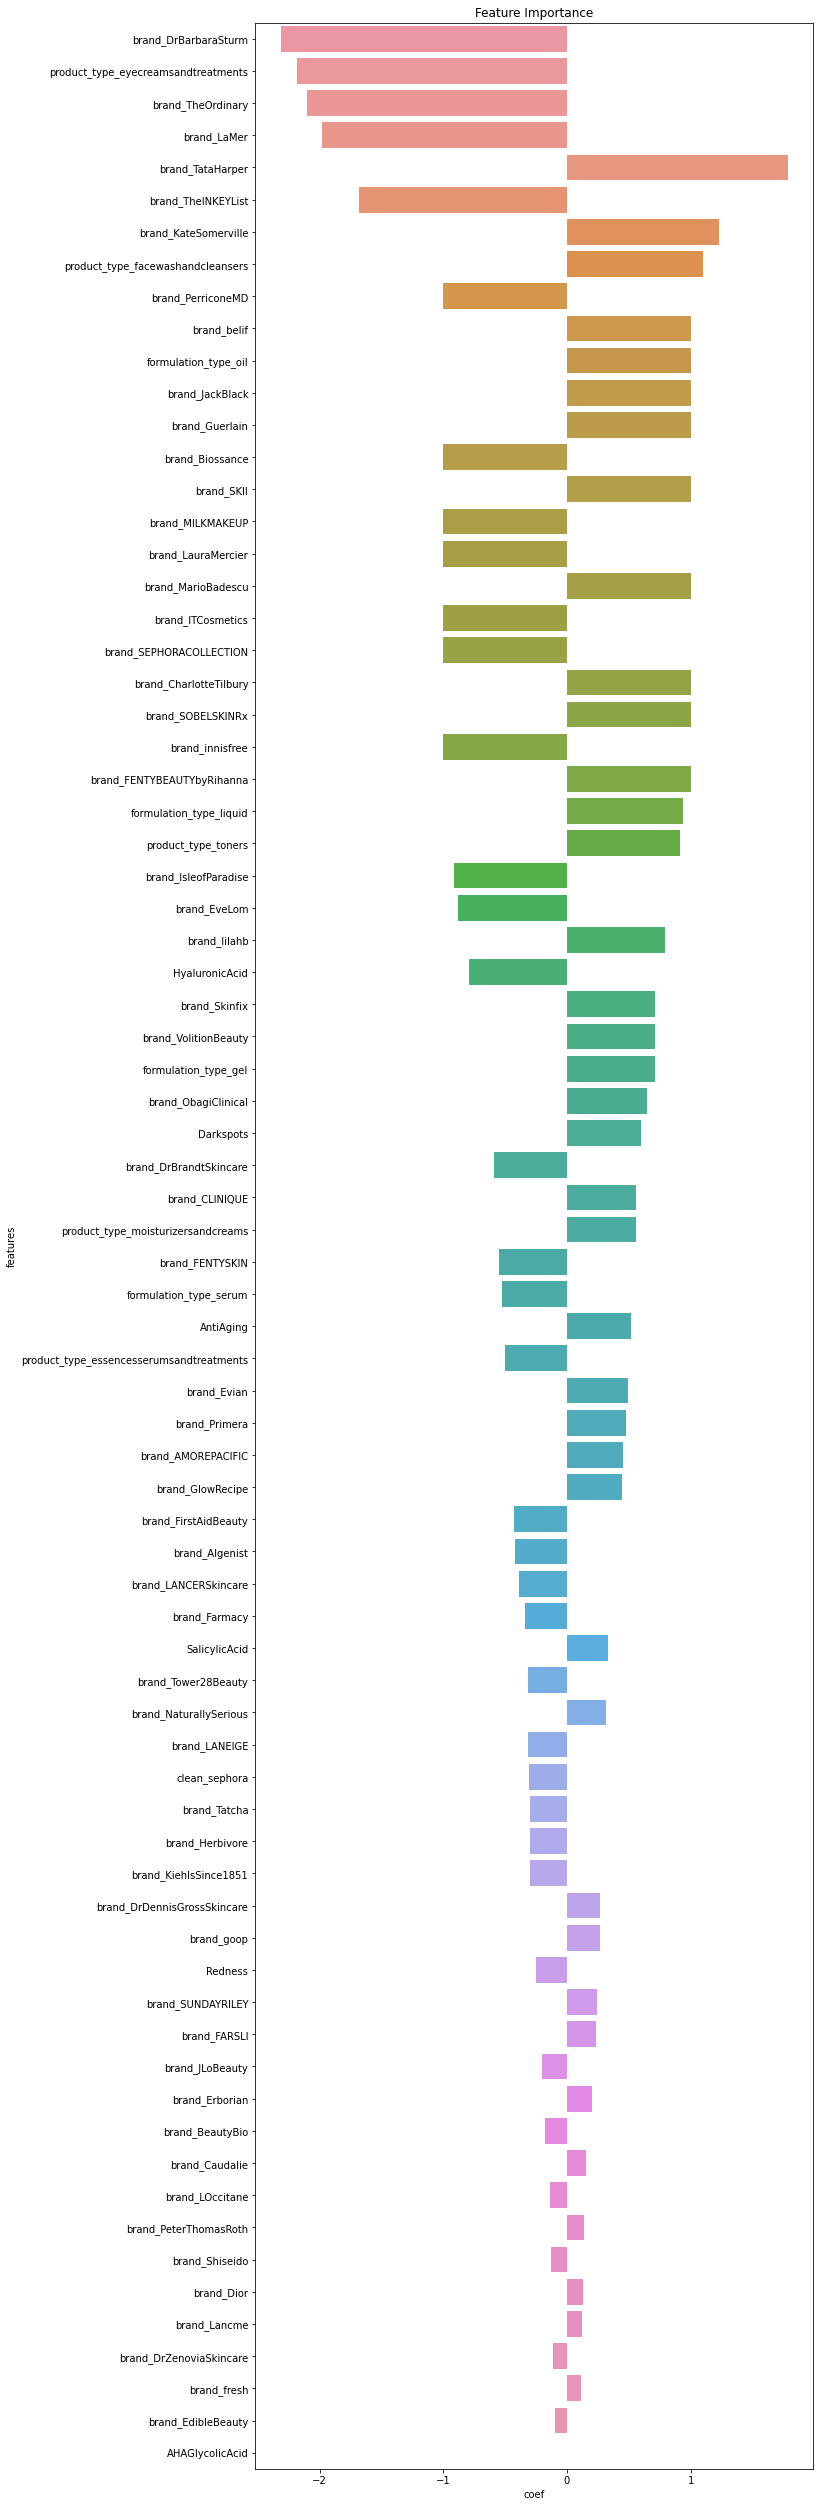

In [798]:
plot_feature_importance(linear, X_tr_sc_select, 'abs_value', (10,45))

______________________________________________________________________

## Saving the model

## Applying the model to predict under or overpricing

_______________

# *Extension*

Are there specific ingredients that potentially drive up price?

### Create new training datasets

<font color='red'> observed that adding the ingredient count has led to overfitting so many times - curse of dimensionality? </font>

In [389]:
with open('../data/processed_data/ingr_count.json', 'r') as file:
    data= json.load(file)
ingr_count=pd.DataFrame.from_dict(data)

Try combining the ingredient counts to other training data sets

In [401]:
X_tr_fullingr = X_tr.join(ingr_count.drop(columns=['product_name']))
X_te_fullingr = X_te.join(ingr_count.drop(columns=['product_name']))

X_tr_sc_fullingr = X_tr_scaled.join(ingr_count.drop(columns=['product_name']))
X_te_sc_fullingr = X_te_scaled.join(ingr_count.drop(columns=['product_name']))

In [441]:
X_tr_sc_lringr = X_tr_sc_select.join(ingr_count.drop(columns=['product_name']))
X_te_sc_lringr = X_te_sc_select.join(ingr_count.drop(columns=['product_name']))
X_tr_lringr = X_tr_select.join(ingr_count.drop(columns=['product_name']))
X_te_lringr = X_te_select.join(ingr_count.drop(columns=['product_name']))

X_tr_svmingr = X_tr_selectsvm.join(ingr_count.drop(columns=['product_name']))
X_te_svmingr = X_te_selectsvm.join(ingr_count.drop(columns=['product_name']))
X_tr_sc_svmingr = X_tr_sc_selectsvm.join(ingr_count.drop(columns=['product_name']))
X_te_sc_svmingr = X_te_sc_selectsvm.join(ingr_count.drop(columns=['product_name']))

### Use existing models with the new training set containing ingredient info

**SVM model - overfits!**

Let's fit the existing linear SVM model on different training sets

<font color='red'> tbd - how would you approach the interpretation of the models? 

In [429]:
eval_model(linear, X_tr_sc_fullingr, y_tr, 5, scores_list, 'SVM - full scaled with ingr count, linear', True)

SVM - full scaled with ingr count, linear

Test scores: (mean, SD)
 Accuracy: 
 (0.563, 0.0316)
 F1_Weighted: 
 (0.5624, 0.0318)
 Precision_Weighted: 
 (0.5664, 0.0287)
 Recall_Weighted: 
 (0.563, 0.0316)

Training scores:
 Accuracy: 
 (0.9976, 0.0005)
 F1_Weighted: 
 (0.9976, 0.0005)
 Precision_Weighted: 
 (0.9976, 0.0005)
 Recall_Weighted: 
 (0.9976, 0.0005)


In [430]:
eval_model(linear, X_tr_sc_lringr, y_tr, 5, scores_list, 'SVM - scaled LR feature set with ingr, linear', True)

SVM - scaled LR feature set with ingr, linear

Test scores: (mean, SD)
 Accuracy: 
 (0.5737, 0.0323)
 F1_Weighted: 
 (0.5741, 0.0334)
 Precision_Weighted: 
 (0.58, 0.035)
 Recall_Weighted: 
 (0.5737, 0.0323)

Training scores:
 Accuracy: 
 (0.9973, 0.0008)
 F1_Weighted: 
 (0.9973, 0.0008)
 Precision_Weighted: 
 (0.9974, 0.0008)
 Recall_Weighted: 
 (0.9973, 0.0008)


In [431]:
eval_model(linear, X_tr_sc_svmingr, y_tr, 5, scores_list, 'SVM - scaled SVM feature set with ingr, linear', True)

SVM - scaled SVM feature set with ingr, linear

Test scores: (mean, SD)
 Accuracy: 
 (0.5694, 0.0286)
 F1_Weighted: 
 (0.569, 0.0301)
 Precision_Weighted: 
 (0.5743, 0.0302)
 Recall_Weighted: 
 (0.5694, 0.0286)

Training scores:
 Accuracy: 
 (0.9973, 0.0008)
 F1_Weighted: 
 (0.9973, 0.0008)
 Precision_Weighted: 
 (0.9974, 0.0008)
 Recall_Weighted: 
 (0.9973, 0.0008)


#### Logistic regression - overfits!

In [434]:
eval_model(logreg_opt, X_tr_sc_fullingr, y_tr, 5, scores_list, 'LR - scaled full feature set with ingr, tuned parameters', True)

LR - scaled full feature set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.5673, 0.0355)
 F1_Weighted: 
 (0.566, 0.0352)
 Precision_Weighted: 
 (0.5689, 0.0351)
 Recall_Weighted: 
 (0.5673, 0.0355)

Training scores:
 Accuracy: 
 (0.9995, 0.0011)
 F1_Weighted: 
 (0.9995, 0.0011)
 Precision_Weighted: 
 (0.9995, 0.0011)
 Recall_Weighted: 
 (0.9995, 0.0011)


In [432]:
eval_model(logreg_opt, X_tr_sc_lringr, y_tr, 5, scores_list, 'LR - scaled LR feature set with ingr, tuned parameters', True)

LR - scaled LR feature set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.5822, 0.0312)
 F1_Weighted: 
 (0.5795, 0.0281)
 Precision_Weighted: 
 (0.5816, 0.0261)
 Recall_Weighted: 
 (0.5822, 0.0312)

Training scores:
 Accuracy: 
 (0.9976, 0.0005)
 F1_Weighted: 
 (0.9976, 0.0005)
 Precision_Weighted: 
 (0.9976, 0.0005)
 Recall_Weighted: 
 (0.9976, 0.0005)


In [433]:
eval_model(logreg_opt, X_tr_sc_svmingr, y_tr, 5, scores_list, 'LR - scaled SVM feature set with ingr, tuned parameters', True)

LR - scaled SVM feature set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.5705, 0.0339)
 F1_Weighted: 
 (0.5667, 0.0335)
 Precision_Weighted: 
 (0.5671, 0.0336)
 Recall_Weighted: 
 (0.5705, 0.0339)

Training scores:
 Accuracy: 
 (0.9976, 0.0005)
 F1_Weighted: 
 (0.9976, 0.0005)
 Precision_Weighted: 
 (0.9976, 0.0005)
 Recall_Weighted: 
 (0.9976, 0.0005)


Both the SVM and logistic regression models overfit.

<font color='red'>  Despite this, it is notable how it's performance on the test set is not remarkably different from general model performance on the smaller training set (i.e. without the ingredients) </font>

**Ensemble methods**

In [435]:
eval_model(rf2, X_tr_fullingr, y_tr, 5, scores_list, 'RF - full feature set with ingr, tuned parameters', True)

RF - full feature set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.563, 0.0279)
 F1_Weighted: 
 (0.5295, 0.0325)
 Precision_Weighted: 
 (0.5533, 0.0351)
 Recall_Weighted: 
 (0.563, 0.0279)

Training scores:
 Accuracy: 
 (0.8133, 0.0132)
 F1_Weighted: 
 (0.8122, 0.0139)
 Precision_Weighted: 
 (0.845, 0.0141)
 Recall_Weighted: 
 (0.8133, 0.0132)


Accuracy score on test: 0.5472636815920398
Average ROC AUC score: 0.7067
{'$': 0.864, '$$$$': 0.7474, '$$': 0.6703, '$$$': 0.5452}
Classification report: 
               precision    recall  f1-score   support

           $       0.60      0.93      0.73        98
          $$       0.65      0.42      0.51       103
         $$$       0.40      0.21      0.27       111
        $$$$       0.50      0.70      0.58        90

    accuracy                           0.55       402
   macro avg       0.54      0.56      0.52       402
weighted avg       0.54      0.55      0.51       402

Confusion matrix, without normalization:
[[91  5  1  1]
 [35 43 18  7]
 [17 15 23 56]
 [ 9  3 15 63]]
Normalized confusion matrix:
[[0.93 0.05 0.01 0.01]
 [0.34 0.42 0.17 0.07]
 [0.15 0.14 0.21 0.5 ]
 [0.1  0.03 0.17 0.7 ]]


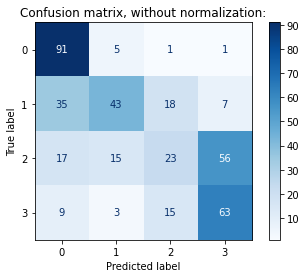

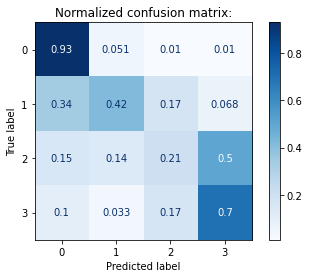

In [805]:
evaluate_test(rf2, X_tr_fullingr,  X_te_fullingr, y_tr, y_te)

In [438]:
eval_model(xgb_opt, X_tr_fullingr, y_tr, 5, scores_list, 'XGB - full feature set with ingr, tuned parameters', True)

[10:24:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:25:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[15:27:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on test: 0.6243781094527363
Average ROC AUC score: 0.7528
{'$': 0.8583, '$$$$': 0.8043, '$$': 0.6917, '$$$': 0.6567}
Classification report: 
               precision    recall  f1-score   support

           $       0.79      0.79      0.79        98
          $$       0.55      0.53      0.54       103
         $$$       0.51      0.50      0.50       111
        $$$$       0.67      0.71      0.69        90

    accuracy                           0.62       402
   macro avg       0.63      0.63      0.63       402
weighted avg       0.62      0.62      0.62       402

Confusion matrix, without normalization:
[[77 14  7  0]
 [16 55 26  6]
 [ 4 26 55 26]
 [ 1  5 20 64]]
Normalized confusion ma

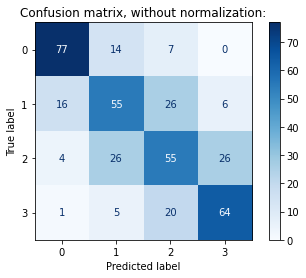

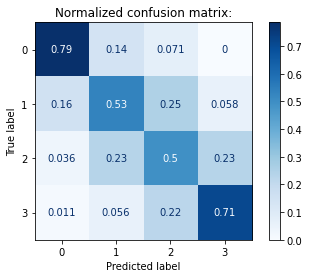

In [804]:
evaluate_test(xgb_opt, X_tr_fullingr,  X_te_fullingr, y_tr, y_te)

In [442]:
eval_model(xgb_opt, X_tr_lringr, y_tr, 5, scores_list, 'XGB - LR set with ingr, tuned parameters', True)

[10:30:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:30:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[15:28:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on test: 0.6268656716417911
Average ROC AUC score: 0.7547
{'$': 0.8634, '$$$$': 0.8082, '$$': 0.6869, '$$$': 0.6601}
Classification report: 
               precision    recall  f1-score   support

           $       0.79      0.80      0.79        98
          $$       0.55      0.52      0.53       103
         $$$       0.52      0.50      0.51       111
        $$$$       0.66      0.72      0.69        90

    accuracy                           0.63       402
   macro avg       0.63      0.63      0.63       402
weighted avg       0.62      0.63      0.62       402

Confusion matrix, without normalization:
[[78 13  7  0]
 [16 54 26  7]
 [ 4 26 55 26]
 [ 1  6 18 65]]
Normalized confusion ma

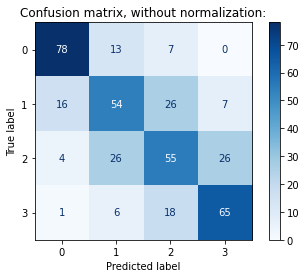

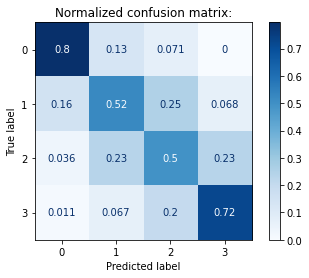

In [806]:
evaluate_test(xgb_opt, X_tr_lringr,  X_te_lringr, y_tr, y_te)

In [443]:
eval_model(xgb_opt, X_tr_svmingr, y_tr, 5, scores_list, 'XGB - SVM set with ingr, tuned parameters', True)

[10:30:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:31:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

<NOTE> 

*Gradient boosting*

In [439]:
eval_model(gb, X_tr_fullingr, y_tr, 5, scores_list, 'GB - full feature set with ingr, tuned parameters', True)

GB - full feature set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.5737, 0.0146)
 F1_Weighted: 
 (0.5766, 0.0135)
 Precision_Weighted: 
 (0.584, 0.0142)
 Recall_Weighted: 
 (0.5737, 0.0146)

Training scores:
 Accuracy: 
 (0.7756, 0.005)
 F1_Weighted: 
 (0.7763, 0.0051)
 Precision_Weighted: 
 (0.7786, 0.0054)
 Recall_Weighted: 
 (0.7756, 0.005)


In [444]:
eval_model(gb, X_tr_lringr, y_tr, 5, scores_list, 'GB - LR set with ingr, tuned parameters', True)

GB - LR set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.5759, 0.0151)
 F1_Weighted: 
 (0.5781, 0.0154)
 Precision_Weighted: 
 (0.5852, 0.0156)
 Recall_Weighted: 
 (0.5759, 0.0151)

Training scores:
 Accuracy: 
 (0.7735, 0.0081)
 F1_Weighted: 
 (0.7743, 0.008)
 Precision_Weighted: 
 (0.7773, 0.0083)
 Recall_Weighted: 
 (0.7735, 0.0081)


In [445]:
eval_model(gb, X_tr_svmingr, y_tr, 5, scores_list, 'GB - SVM set with ingr, tuned parameters', True)

GB - SVM set with ingr, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.5887, 0.0254)
 F1_Weighted: 
 (0.5913, 0.028)
 Precision_Weighted: 
 (0.5993, 0.033)
 Recall_Weighted: 
 (0.5887, 0.0254)

Training scores:
 Accuracy: 
 (0.7559, 0.015)
 F1_Weighted: 
 (0.757, 0.0155)
 Precision_Weighted: 
 (0.7615, 0.0154)
 Recall_Weighted: 
 (0.7559, 0.015)


**Evaluate selected models on the test set with ingredient count**

The best model was XG Boost. 

[10:41:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on test: 0.6268656716417911
Average ROC AUC score: 0.7547
{'$': 0.8634, '$$$$': 0.8082, '$$': 0.6869, '$$$': 0.6601}
Classification report: 
               precision    recall  f1-score   support

           $       0.79      0.80      0.79        98
          $$       0.55      0.52      0.53       103
         $$$       0.52      0.50      0.51       111
        $$$$       0.66      0.72      0.69        90

    accuracy                           0.63       402
   macro avg       0.63      0.63      0.63       402
weighted avg       0.62      0.63      0.62       402

Confusion matrix, without normalization:
[[78 13  7  0]
 [16 54 26  7]
 [ 4 26 55 26]
 [ 1  6 18 65]]
Normalized confusion ma

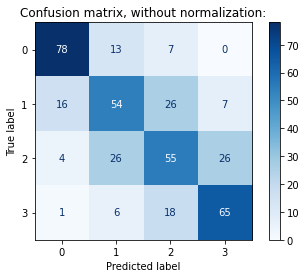

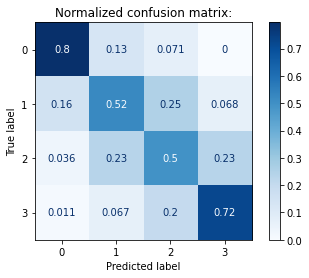

In [451]:
#How well does it perform on the actual test set? 
evaluate_test(xgb_opt, X_tr_lringr, X_te_lringr, y_tr, y_te, 'XGB - LR set with ingr, tuned parameters')

In [452]:
xgb_opt.fit(X_tr_lringr, y_tr)
y_te_pred = xgb_opt.predict(X_te_lringr)
matthews_corrcoef(y_te, y_te_pred)

[10:42:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5023625057478254

[10:40:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on test: 0.6243781094527363
Average ROC AUC score: 0.7528
{0: 0.8583, 1: 0.6917, 2: 0.6567, 3: 0.8043}
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        98
           1       0.55      0.53      0.54       103
           2       0.51      0.50      0.50       111
           3       0.67      0.71      0.69        90

    accuracy                           0.62       402
   macro avg       0.63      0.63      0.63       402
weighted avg       0.62      0.62      0.62       402

Confusion matrix, without normalization:
[[77 14  7  0]
 [16 55 26  6]
 [ 4 26 55 26]
 [ 1  5 20 64]]
Normalized confusion matrix:
[[0.79 0

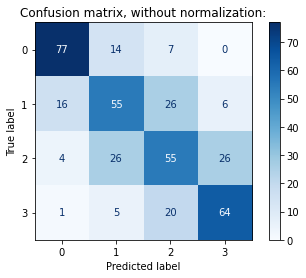

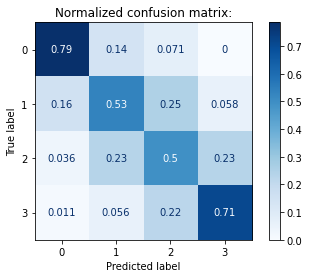

In [450]:
evaluate_test(xgb_opt, X_tr_fullingr, X_te_fullingr, y_tr, y_te, 'XGB - full training set with ingr, tuned parameters')

In [453]:
xgb_opt.fit(X_tr_fullingr, y_tr)
y_te_pred = xgb_opt.predict(X_te_fullingr)
matthews_corrcoef(y_te, y_te_pred)

[10:42:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.4987402337007764

### Tune the hyperparameters of the chosen model

In [454]:
clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = RandomizedSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=5,
                    random_state=123)

grid.fit(X_tr_lringr, y_tr)

[11:04:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [455]:
bestxgb2= grid.best_params_
bestxgb2

{'min_child_weight': 5,
 'max_depth': 5,
 'gamma': 0.2,
 'eta': 0.1,
 'colsample_bytree': 0.5}

In [457]:
#Build xgb model with tuned parameters
xgb_opt2 = xgb.XGBClassifier(min_child_weight= bestxgb2['min_child_weight'], 
                            max_depth= bestxgb2['max_depth'], 
                            gamma= bestxgb2['gamma'], 
                            eta= bestxgb2['eta'], 
                            colsample_bytree= bestxgb2['colsample_bytree'])

In [459]:
eval_model(xgb_opt2, X_tr_lringr, y_tr, 5, scores_list, 'XGBoost - LR feature set with ingr, tuned parameters', True)

[11:05:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:05:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:06:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

[11:07:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score on test: 0.6169154228855721
Average ROC AUC score: 0.7476
{'$': 0.8618, '$$$$': 0.7916, '$$': 0.6787, '$$$': 0.6584}
Classification report: 
               precision    recall  f1-score   support

           $       0.78      0.80      0.79        98
          $$       0.53      0.51      0.52       103
         $$$       0.51      0.50      0.50       111
        $$$$       0.65      0.69      0.67        90

    accuracy                           0.62       402
   macro avg       0.62      0.62      0.62       402
weighted avg       0.61      0.62      0.62       402

Confusion matrix, without normalization:
[[78 13  7  0]
 [18 53 24  8]
 [ 3 28 55 25]
 [ 1  6 21 62]]
Normalized confusion ma

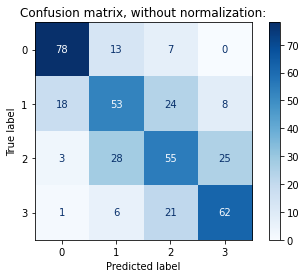

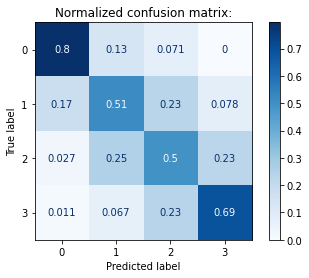

In [460]:
evaluate_test(xgb_opt2, X_tr_lringr, X_te_lringr, y_tr, y_te, 'XGBoost - LR feature set with ingr, tuned parameters')

<font color='red'> Model seems to be overfitting here with 90%+ on cv test set - should this be a reason for concern? On the test set, however, it seems to be performing at a comparable level to our part 1 model (without ingr). 

not sure if i should use xgb_opt or xgb_opt2
  
</font>

Are some ingredients more predictive than others? 

[15:48:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


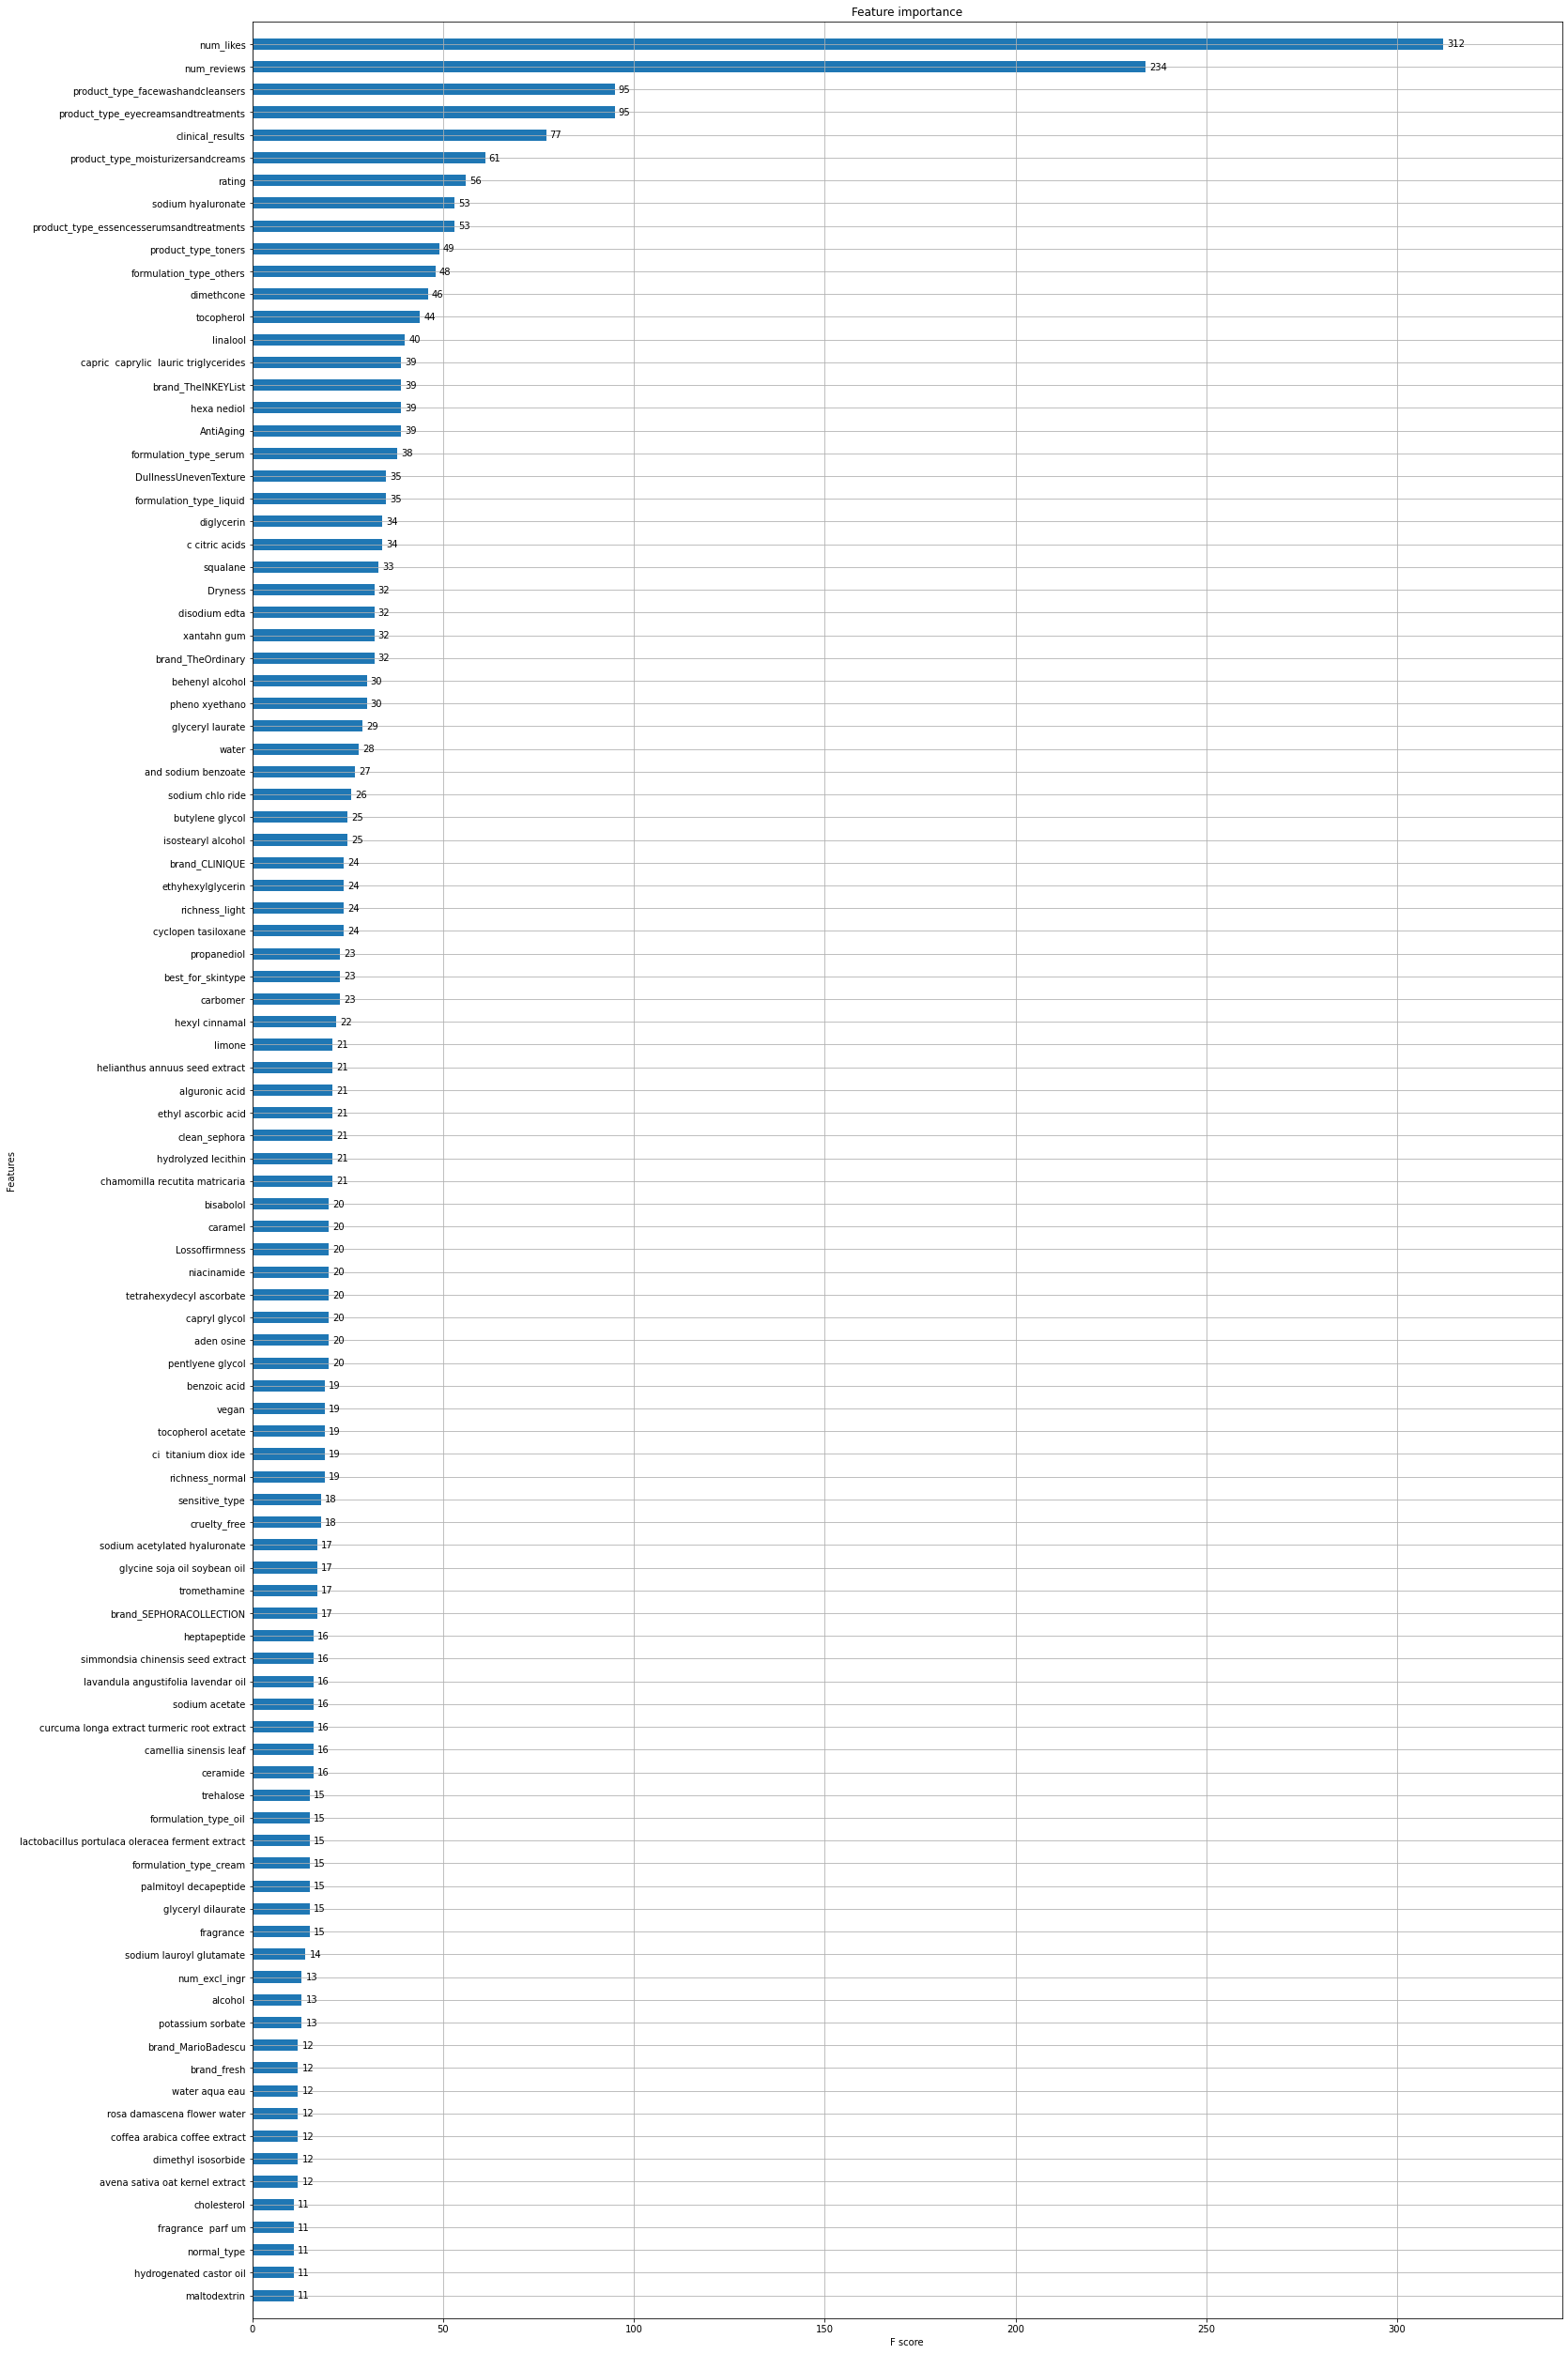

In [813]:
xgb_opt2.fit(X_tr_lringr,y_tr_num)
ax= plot_importance(xgb_opt2, max_num_features=100, height=0.5)
fig = ax.figure
fig.set_size_inches(25, 45)
plt.show();

## Model explainability

In [472]:
#! pip install shap

### SHAP

In [519]:
xgb_opt2.fit(X_tr_lringr, y_tr_num)

[19:24:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.1, gamma=0.2,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

*General model*

In [474]:
explainer = shap.TreeExplainer(xgb_opt2, X_tr_lringr)
shap_values = explainer.shap_values(X_tr_lringr)

 99%|===================| 3694/3744 [00:13<00:00]        

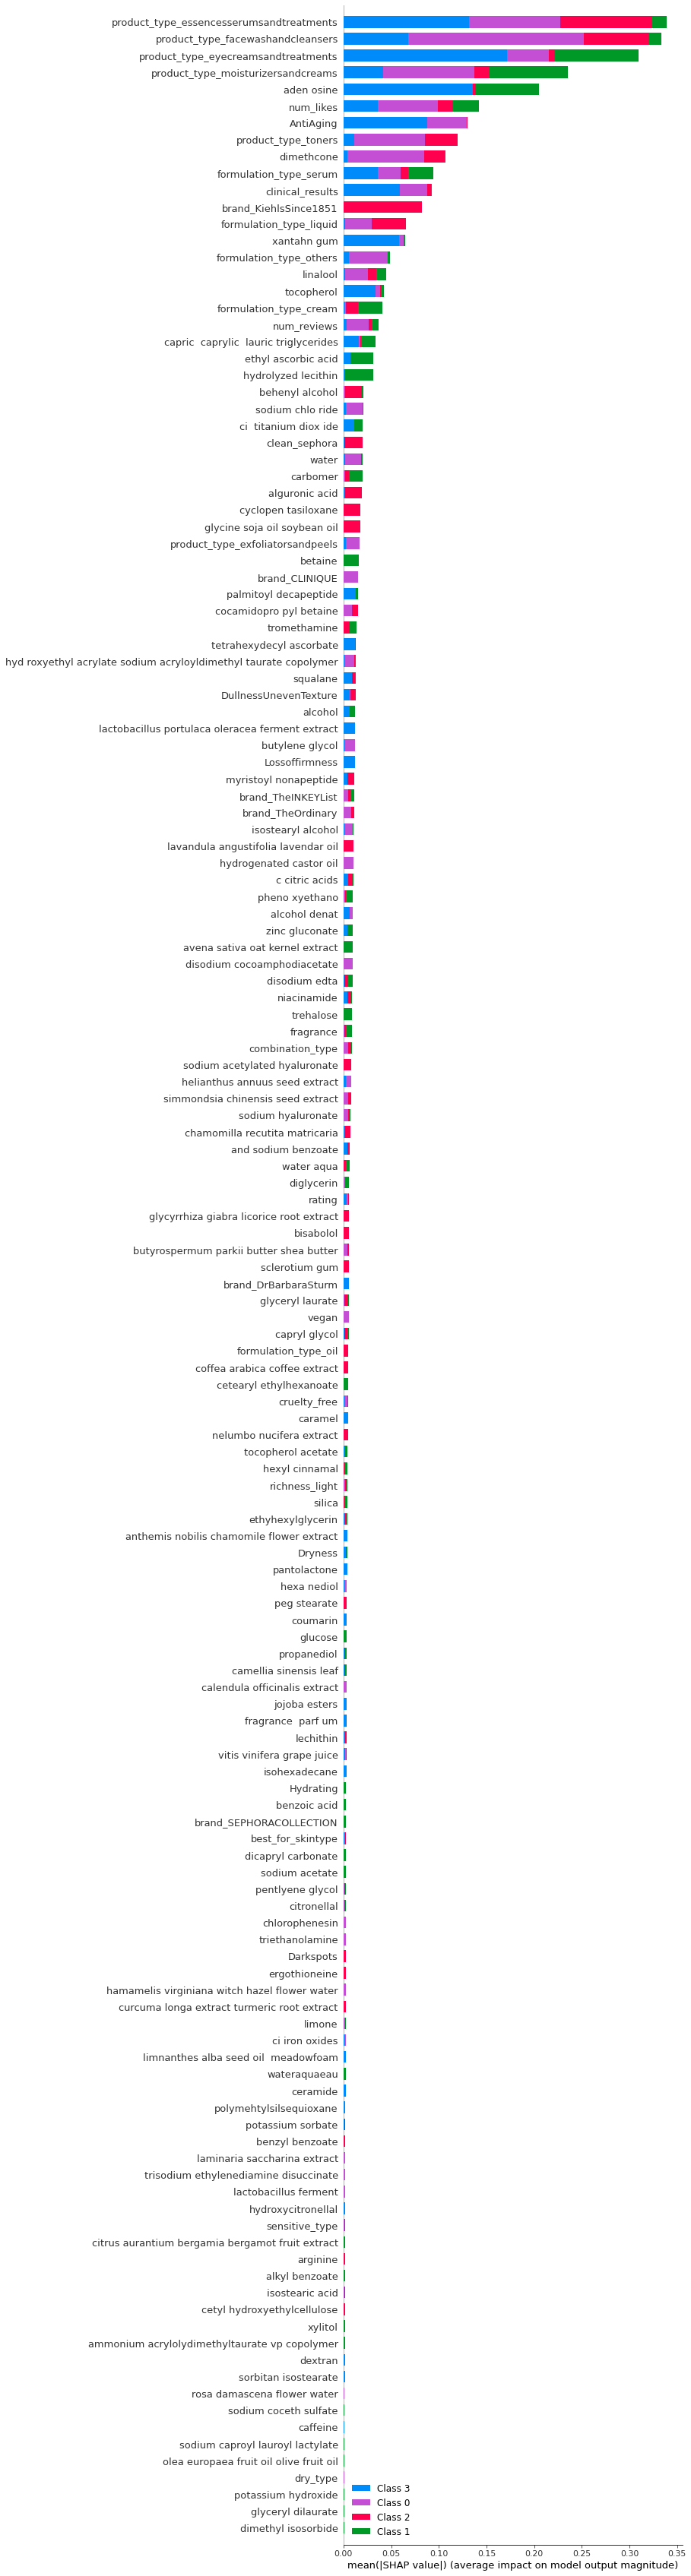

In [612]:
shap.summary_plot(shap_values, X_tr_lringr, max_display= 50, plot_type='bar')

*Explaining individual predictions*

In [768]:
#take a random row of data
X_rand = X_te_lringr.sample(1, random_state = 105)
idx = X_rand.index[0]
display(df1.loc[[idx]])

#generate a prediction for the row
rand_pred = xgb_opt2.predict(X_rand)
rand_proba = xgb_opt2.predict_proba(X_rand)

print(f'Predicted Probability for each class: {rand_proba}')
print(f'Predicted Class: {rand_pred}')
print(f'Actual classification: ${df1.affordability[X_rand.index][0]}')
print(f'Actual price per volume: ${df1.pricepervol[X_rand.index][0]}')

print('$$ - 0 ; $$$ - 1, $$$$ - 2, $$$$$ - 3')

product_name  num_likes  rating  \
690  Dior One Essential Skin Boosting Super Serum       6700     4.5   

     num_reviews  sensitive_type  combination_type  oily_type  normal_type  \
690           45               0                 1          0            1   

     dry_type  clean_sephora  ...  brand_belif  brand_fresh  brand_goop  \
690         1              0  ...            0            0           0   

     brand_innisfree  brand_lilahb brand_philosophy  brand_rmsbeauty  \
690                0             0                0                0   

     brand_tarte  affordability  affordability_bins  
690            0           $$$$                 4th  

[1 rows x 181 columns]

Predicted Probability for each class: [[0.18 0.08 0.29 0.46]]
Predicted Class: [3]
Actual classification: $$$$$
Actual price per volume: $100.0
$$ - 0 ; $$$ - 1, $$$$ - 2, $$$$$ - 3


In [769]:
# Initialize JavaScript visualizations in notebook environment
shap.initjs()
# Define a tree explainer for the built model
explainer = shap.TreeExplainer(xgb_opt2)
# obtain shap values for the row of the test data
shap_values = explainer.shap_values(X_te_lringr.loc[[idx]])


shap.initjs()
for which_class in range(0,4):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_te_lringr.loc[[idx]]))

In [792]:
#List of test product names
test_prods = X_te_lringr.index.to_list()
df1.loc[test_prods].product_name[4]

'Summer Fridays Soft Reset AHA Exfoliating Solution'

In [789]:
def explain_instance(prod, model, test_set):
    '''
    
    '''
    idx= df1.loc[df1.product_name==prod].index[0]
    X = test_set.loc[[idx]]
    #generate a prediction for the row
    rand_pred = model.predict(X)
    rand_proba = model.predict_proba(X)

    print('$$ - 0 ; $$$ - 1, $$$$ - 2, $$$$$ - 3')
    print(f'Predicted Class: {rand_pred}')
    print(f'Actual classification: ${df1.affordability[X_rand.index][0]}')
    print(f'Actual price per volume: ${df1.pricepervol[X_rand.index][0]}')
    print(f'Predicted Probability for each class: {rand_proba}')

    shap.initjs()
    # Define a tree explainer for the built model
    explainer2 = shap.TreeExplainer(model)
    # obtain shap values for the row of the test data
    shap_values2 = explainer2.shap_values(test_set.loc[[idx]])


    shap.initjs()
    for which_class in range(0,4):
        display(shap.force_plot(explainer2.expected_value[which_class], shap_values2[which_class], test_set.loc[[idx]]))

In [793]:
explain_instance('Summer Fridays Soft Reset AHA Exfoliating Solution', xgb_opt2, X_te_lringr)

$$ - 0 ; $$$ - 1, $$$$ - 2, $$$$$ - 3
Predicted Class: [2]
Actual classification: $$$$$
Actual price per volume: $100.0
Predicted Probability for each class: [[0.15 0.23 0.59 0.03]]


_____________________________

### The final model

### for future projects

few thoughts on the next steps / future variations of the study

clustering?
price per volume itself 
price range, based on set increments (instead of using quantiles) 

justify why we should use one model over the other

confusing the middle 2 classes, hence, lower accuracy but if we had combined both and distinguished between cheap, average, premium, maybe it could yield more robust results

predict price itself

remove brand as a predictor of affordability - without thinking about brand/product positioning, how would the product price prediction change?

_______________________________________